<a href="https://colab.research.google.com/github/Sabha95/Machine_Learning-Assig/blob/main/Getting_started_Notebook_for_Students_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CA684 Machine Learning Assignment Spring 2024

Dublin City University has teamed up with **Etsy** to create the 2024 CA684 Machine Learning assignment.

## Etsy.com

Etsy is the global marketplace for unique and creative goods. It’s home to a universe of special, extraordinary items, from unique handcrafted pieces to vintage treasures. Etsy operates two-sided online marketplaces that collectively connect nearly 100 million passionate and creative buyers and 7.7 million sellers around the world.

Buyers come to the Etsy marketplace for meaningful, one-of-a-kind items handcrafted and curated with passion and expertise by our creative entrepreneurs. We are focused on attracting potential buyers to Etsy for everyday items that have meaning and those “special” purchase occasions that happen throughout the year. These include items that reflect an individual’s unique style; gifting that demonstrates thought and care; and celebrations that express creativity and fun.

On Etsy, someone searches for …
- Wall art every two seconds
- Wedding-related items every two seconds
- Gift-related items every second
- Antique or vintage items every half a second

## Challenge

Etsy has nearly 100 Million active listings on the etsy.com marketplace for sale from more than 5 million active sellers. You are provided a subset of those products as the training data.

The task is to leverage the training dataset to learn patterns from and to predict the following attributes on an unseen test dataset given a products’ information:

- top category id
- bottom category id

The goal is to maximize F1 for each of the classes on each attribute to predict (top category, bottom category). Your approaches and models will be benchmarked against a hidden test dataset.

Bonus points will be given for submissions that:

- visualize some learned representations or embeddings and show that similar items cluster together
- compares the performance of pre-trained embeddings taken from hubs or papers with a fine-tuned model


## Getting Started

Here is some sample code to get you started on the challenge!

Happy Hacking!

In [ ]:
pip install tensorflow

In [23]:
# libraries
import io
import os
from datetime import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn import metrics
from sklearn.feature_selection import chi2, mutual_info_classif
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

# Matplotlib configuration
font = { 'family': 'DejaVu Sans', 'weight': 'bold', 'size': 16 }
plt.rc('font', **font)


In [24]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# set random seed
np.random.seed(seed=42)

## Dataset

The train and test datasets are shared in **parquet** format.

In order to download the dataset, please sign the NDA first.

In [25]:
PATH = f"/content/gdrive/MyDrive/machine_Learning_Assig"
!ls {PATH}
parquet_filenames_train = !ls {PATH}/train

filenames_string = " ".join(parquet_filenames_train)
parquet_filenames_train = filenames_string.split()
parquet_filenames_train[:3]

f"Number of files in train: {len(parquet_filenames_train):,}"

test			  train		      train_preProcessed2
test_preProcessed_bottom  train_preProcessed  train_preProcessed_bottom


'Number of files in train: 362'

In [26]:
parquet_filenames_test = !ls {PATH}/test
filenames_string = " ".join(parquet_filenames_test)
parquet_filenames_test = filenames_string.split()


In [27]:
parquet_filenames_test[:3]

['part-00000-of-00362.parquet.parquet',
 'part-00181-of-00362.parquet.parquet',
 'part-00001-of-00362.parquet.parquet']

In [28]:
f"Number of files in test: {len(parquet_filenames_test):,}"

'Number of files in test: 362'

## Exploratory Data Analysis

It is important to familiarize yourself with the dataset by using measures of centrality (e.g. mean) and statistical dispersion (e.g. variance) and data visualization methods. The following is just some Pandas preprocessing and Matplotlib visualizations to get you started. Feel free to explore the data much further and come up with ideas that might help you in the task!

### Training Dataset

This dataset can be used to train models and learn patterns from.

In [ ]:
from pandas import ExcelWriter
from google.colab import files
writer = ExcelWriter('my_excel_file.xlsx')

In [29]:

def read_data(folder, filenames):
    """ Read parquet data from mutiple files """

    dataframes = [
        pd.read_parquet(f"{PATH}/{folder}/{filename}")
        for filename in filenames

    ]

    return pd.concat(dataframes)

In [10]:
df_train_top = read_data("train", parquet_filenames_train)



***New DataFrame for Bottom Category***

In [11]:
df_train_bottom = read_data("train", parquet_filenames_train)

In [ ]:
f"Length",len(df_train)

('Length', 229624)

In [ ]:
df_train_top.head()

,product_id,title,description,tags,type,room,craft_type,recipient,material,occasion,...,shape,pattern,bottom_category_id,bottom_category_text,top_category_id,top_category_text,primary_color_id,primary_color_text,secondary_color_id,secondary_color_text
0,699437355,Children&#39;s circle skirt BLUE GALAXY made o...,The fuxandfriends children&#39;s full circle s...,,physical,,,,,,...,,,426,clothing.girls_clothing.skirts,5,clothing,2,blue,2,blue
1,1323699538,"Cow Birthday Tutu for kids, Farm Theme Bday Ou...",💄This listing is for the TUTU ONLY (double rib...,"birthday outfit,girls birthday shirt,Tutu outf...",physical,,,,,birthday,...,,animal print,426,clothing.girls_clothing.skirts,5,clothing,11,pink,1,black
2,1142910558,"Zebra print tutu, animal print Skirt, World bo...",All tutus are handmade to order with two layer...,"black and white tutu,striped skirt,zebra tutu,...",physical,,,,,,...,,animal print,426,clothing.girls_clothing.skirts,5,clothing,17,white,1,black
3,1320296928,"Lilac Tutu Rainbow Dots // Girl&#39;s Tutu, Tu...",Step aside because the princess pop star is he...,"tutu,girls skirt,sparkling tutu,fun skirt,ball...",physical,,,,,birthday,...,,,426,clothing.girls_clothing.skirts,5,clothing,12,purple,13,rainbow
4,854901795,Bumblebee tutu yellow and black tutu halloween...,"Sparkle, shimmer, twirl and spin,\nThis tutu&#...","dog tutu,fluffy tutu,dance tutu,skirt,flower g...",physical,,,,,birthday,...,,,426,clothing.girls_clothing.skirts,5,clothing,18,yellow,1,black


# **Starting Feature selection for Top Category**


Cramér's V Results:
               Feature  Cramér's V
1           craft_type    0.209483
3             material    0.196217
2            recipient    0.177280
4             occasion    0.173182
6          art_subject    0.137554
9              pattern    0.108883
10  primary_color_text    0.102762
0                 room    0.101867
5              holiday    0.082195
8                shape    0.079161
7                style    0.057330

Mutual Information Results:
               Feature  MI Score
1           craft_type  0.232086
3             material  0.146642
4             occasion  0.140020
2            recipient  0.083623
10  primary_color_text  0.069475
9              pattern  0.057681
0                 room  0.055920
5              holiday  0.045186
6          art_subject  0.036419
7                style  0.018732
8                shape  0.017138


<ipython-input-13-a7e65495994a>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Feature", y="MI Score", data=mi_results, palette="viridis")


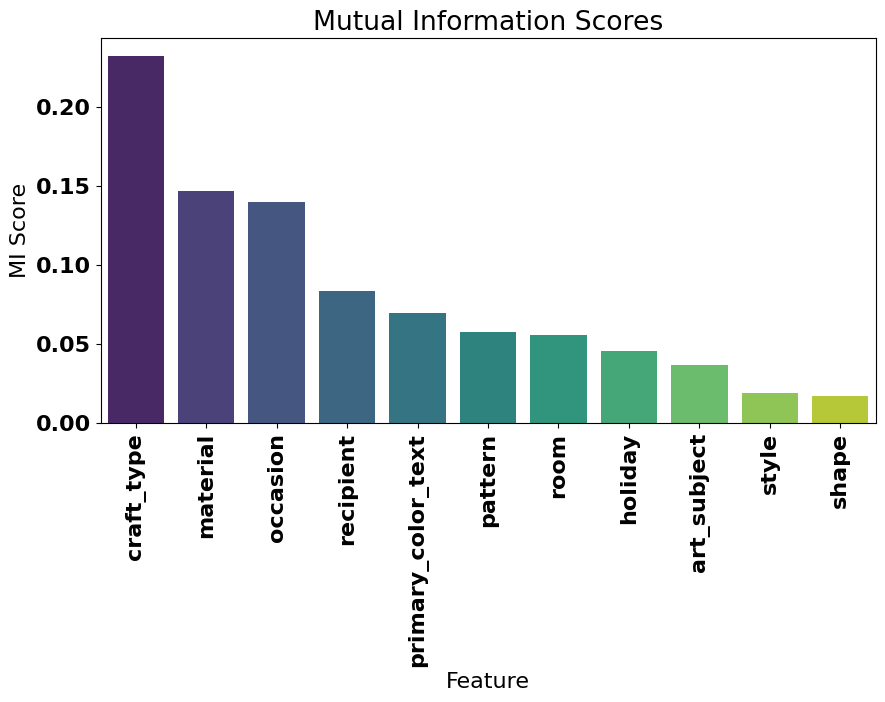

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

# Define categorical features
categorical_features = ["room", "craft_type", "recipient", "material", "occasion",
                        "holiday", "art_subject", "style", "shape", "pattern",
                        "primary_color_text"]

# Target variable
target = "top_category_id"

# Encode target if it's categorical
encoder = LabelEncoder()
df_train_top[target] = encoder.fit_transform(df_train_top[target])

# Encode categorical features
for col in categorical_features:
    df_train_top[col] = encoder.fit_transform(df_train_top[col])

# ------------------ 1. Cramér's V ------------------
def cramers_v(x, y):
    """ Compute Cramér's V for categorical variables """
    confusion_matrix = pd.crosstab(x, y)
    chi2_stat = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2_stat / (n * (min(r, k) - 1)))

# Compute Cramér's V for each categorical feature
cramers_results = {col: cramers_v(df_train_top[col], df_train_top[target]) for col in categorical_features}
cramers_df = pd.DataFrame(cramers_results.items(), columns=["Feature", "Cramér's V"])
cramers_df.sort_values(by="Cramér's V", ascending=False, inplace=True)

print("\nCramér's V Results:")
print(cramers_df)

# ------------------ 2. Mutual Information (MI) ------------------
mi_scores = mutual_info_classif(df_train_top[categorical_features], df_train_top[target], discrete_features=True)
mi_results = pd.DataFrame({"Feature": categorical_features, "MI Score": mi_scores})
mi_results.sort_values(by="MI Score", ascending=False, inplace=True)

print("\nMutual Information Results:")
print(mi_results)

# ------------------ 3. Visualization ------------------
plt.figure(figsize=(10, 5))
sns.barplot(x="Feature", y="MI Score", data=mi_results, palette="viridis")
plt.xticks(rotation=90)
plt.title("Mutual Information Scores")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import chi2, mutual_info_classif
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate Cramer's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2_stat = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2_stat / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Load your dataset (replace 'your_data.csv' with your actual file)
# df = pd.read_csv('your_data.csv')
# If you're data is in another format, adjust accordingly

# For demonstration, I'll assume your dataframe is already loaded as df
# Categorical variables to analyze
cat_vars = ['room', 'craft_type', 'recipient', 'material', 'occasion',
            'holiday', 'art_subject', 'style', 'shape', 'pattern',
            'primary_color_id', 'secondary_color_id']

# Target variable
target = 'top_category_id'

# 1. Calculate Cramer's V for all categorical variables against the target
cramer_results = {}
for var in cat_vars:
    try:
        cramer_results[var] = cramers_v(df_train_top[var],df_train_top[target])
    except (ValueError, KeyError) as e:
        print(f"Error calculating Cramer's V for {var}: {e}")
        cramer_results[var] = np.nan

# Sort results by correlation strength
cramer_df = pd.DataFrame(list(cramer_results.items()), columns=['Feature', 'Cramer\'s V'])
cramer_df = cramer_df.sort_values('Cramer\'s V', ascending=False)

# 2. Chi-square test for independence
chi2_results = {}
for var in cat_vars:
    try:
        # Create contingency table
        contingency = pd.crosstab(df_train_top[var], df_train_top[target])
        # Calculate chi-square and p-value
        chi2_stat, p_val, _, _ = chi2_contingency(contingency)
        chi2_results[var] = {'chi2': chi2_stat, 'p_value': p_val}
    except (ValueError, KeyError) as e:
        print(f"Error calculating Chi-square for {var}: {e}")
        chi2_results[var] = {'chi2': np.nan, 'p_value': np.nan}

# Convert to DataFrame for easier viewing
chi2_df = pd.DataFrame(chi2_results).T
chi2_df = chi2_df.sort_values('chi2', ascending=False)

# 3. Mutual Information
mi_results = {}
for var in cat_vars:
    try:
        # Convert to numeric labels if needed
        x = pd.factorize(df_train_top[var])[0]
        y = pd.factorize(df_train_top[target])[0]
        # Calculate mutual information
        mi = mutual_info_classif(x.reshape(-1, 1), y, discrete_features=True)[0]
        mi_results[var] = mi
    except (ValueError, KeyError) as e:
        print(f"Error calculating Mutual Information for {var}: {e}")
        mi_results[var] = np.nan

# Convert to DataFrame
mi_df = pd.DataFrame(list(mi_results.items()), columns=['Feature', 'Mutual Information'])
mi_df = mi_df.sort_values('Mutual Information', ascending=False)

# Visualizing results
plt.figure(figsize=(12, 8))

# Plot Cramer's V results
plt.subplot(3, 1, 1)
sns.barplot(x='Cramer\'s V', y='Feature', data=cramer_df)
plt.title('Feature Importance by Cramer\'s V')

# Plot Chi-square results
plt.subplot(3, 1, 2)
sns.barplot(x='chi2', y=chi2_df.index, data=chi2_df.reset_index())
plt.title('Feature Importance by Chi-square Statistic')

# Plot Mutual Information results
plt.subplot(3, 1, 3)
sns.barplot(x='Mutual Information', y='Feature', data=mi_df)
plt.title('Feature Importance by Mutual Information')

plt.tight_layout()
plt.show()

# Print top features by each metric
print("\nTop Features by Cramer's V:")
print(cramer_df.head())

print("\nTop Features by Chi-square:")
print(chi2_df.head())

print("\nTop Features by Mutual Information:")
print(mi_df.head())

# Create a combined ranking
features_ranking = pd.DataFrame({'Feature': cat_vars})
features_ranking['Cramer_V_Rank'] = [list(cramer_df['Feature']).index(f) if f in list(cramer_df['Feature']) else np.nan for f in cat_vars]
features_ranking['Chi2_Rank'] = [chi2_df.index.get_loc(f) if f in chi2_df.index else np.nan for f in cat_vars]
features_ranking['MI_Rank'] = [list(mi_df['Feature']).index(f) if f in list(mi_df['Feature']) else np.nan for f in cat_vars]
features_ranking['Avg_Rank'] = features_ranking[['Cramer_V_Rank', 'Chi2_Rank', 'MI_Rank']].mean(axis=1)
features_ranking = features_ranking.sort_values('Avg_Rank')

print("\nCombined Feature Ranking:")
print(features_ranking)

### **Droping Unwanted columns**

In [ ]:
columns_to_drop = ['product_id', 'type', 'room', 'holiday', 'art_subject', 'style', 'shape', 'pattern', 'primary_color_id', 'secondary_color_id', 'secondary_color_text']
df_train_top = df_train_top.drop(columns=columns_to_drop, errors='ignore')


### **Applying Pre-Processng techniques on text based columns**

In [ ]:
pip install pandas nltk spacy

### *MultiThreading - implementation for pre process*

In [ ]:
# CA684 Machine Learning Assignment Spring 2024
# ... (rest of your previous code) ...

# **Applying Pre-Processng techniques on text based columns**
# ***Title - column***
# ... (MCq 25 questions and 1/3 negative marking comment) ...
import pandas as pd
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import concurrent.futures

# Load resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
nlp = spacy.load("en_core_web_sm")

# Function to preprocess text
def preprocess_text(text):
    if pd.isna(text):
        return ""

    text = text.lower()  # Lowercase
    tokens = nltk.word_tokenize(text)  # Tokenize

    # Remove stopwords
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]

    # Lemmatization with spaCy
    doc = nlp(" ".join(filtered_tokens))
    lemmatized = [token.lemma_ for token in doc]

    # Stemming with NLTK
    stemmed = [stemmer.stem(word) for word in filtered_tokens]

    return {
        "cleaned": " ".join(filtered_tokens),
        "lemmatized": " ".join(lemmatized),
        "stemmed": " ".join(stemmed)
    }

# Apply preprocessing using multithreading
def process_column(col):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(preprocess_text, df_train_top[col]))

    df_train_top[f"{col}_cleaned"] = [r['cleaned'] for r in results]
    df_train_top[f"{col}_lemmatized"] = [r['lemmatized'] for r in results]
    df_train_top[f"{col}_stemmed"] = [r['stemmed'] for r in results]

# Process each text column in parallel
with concurrent.futures.ThreadPoolExecutor() as executor:
    executor.map(process_column, ['title','description','tags'])

print("Done Pre Processing , now saving the file")

import os

save_path = "/content/gdrive/MyDrive/machine_Learning_Assig/train_preProcessed"
os.makedirs(save_path, exist_ok=True)  # Create the folder if it doesn't exist

# Save as parquet
df_train_top.to_parquet(os.path.join(save_path, "train_preprocessed.parquet"), index=False)

# Save as CSV
df_train_top.to_csv(os.path.join(save_path, "train_preprocessed.csv"), index=False)

# Save as XLSX (might take longer for large datasets)
# df_train_top.to_excel(os.path.join(save_path, "train_preprocessed.xlsx"), index=False)

print("Processed DataFrame saved successfully!")





[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Done Pre Processing , now saving the file


# ***New DataFrame for Preprocessed Data***

In [ ]:
df_train_top2 = pd.read_parquet(f"/content/gdrive/MyDrive/machine_Learning_Assig/train_preProcessed")

{'/content/gdrive/MyDrive/machine_learning_Assignment'}


## ***Merged Text Data into one columm***

In [ ]:
from multiprocessing import Pool, cpu_count
# Define a helper function that removes duplicate words while preserving their first occurrence.
def remove_duplicates(text):
    seen = set()
    result = []
    for word in text.split():
        if word not in seen:
            seen.add(word)
            result.append(word)
    return " ".join(result)

# Define a function that takes in a row (as an array of strings from the text columns),
# concatenates the fields, and removes duplicate words.
def combine_and_clean(row):
    text = ' '.join(row)  # combine text from multiple columns
    return remove_duplicates(text)

# Specify the text columns to combine.
text_features = ['title_cleaned', 'title_lemmatized', 'title_stemmed','tags_cleaned','tags_lemmatized','tags_stemmed',
                 'description_cleaned','description_lemmatized','description_stemmed']

# Convert the text_features columns to a numpy array where each row is a list of strings.
text_data = df_train_top2[text_features].values

# Use multiprocessing to apply combine_and_clean in parallel.
with Pool(cpu_count()) as pool:
    combined_text = pool.map(combine_and_clean, text_data)

# Add the new column to the dataframe.
df_train_top2['combined_text'] = combined_text



In [ ]:
df_train_top2.head()

,craft_type,recipient,material,occasion,bottom_category_id,bottom_category_text,top_category_id,top_category_text,primary_color_text,combined_text
0,,,,,426,clothing.girls_clothing.skirts,5,clothing,blue,children 39 circle skirt blue galaxy made ligh...
1,,,,birthday,426,clothing.girls_clothing.skirts,5,clothing,pink,cow birthday tutu kids farm theme bday outfit ...
2,,,,,426,clothing.girls_clothing.skirts,5,clothing,white,zebra print tutu animal skirt world book day c...
3,,,,birthday,426,clothing.girls_clothing.skirts,5,clothing,purple,lilac tutu rainbow dots girl 39 tulle skirt ba...
4,,,,birthday,426,clothing.girls_clothing.skirts,5,clothing,yellow,bumblebee tutu yellow black halloween kids tod...


## ***Removing text based columns after merging***


In [ ]:
columns_to_drop = ['title_cleaned', 'title_lemmatized', 'title_stemmed','tags_cleaned','tags_lemmatized','tags_stemmed',
                 'description_cleaned','description_lemmatized','description_stemmed','title','description','tags']
df_train_top2 = df_train_top2.drop(columns=columns_to_drop, errors='ignore')


## ***Applying Frequency Encoding for Categorical columns- due to high cardinality ***

In [ ]:
import pandas as pd

# Assuming df is your dataframe
high_card_cols = [
    'craft_type',
    'recipient',
    'material',
    'occasion',
    'primary_color_text'
]

# Apply frequency encoding
for col in high_card_cols:
    freq_map = df_train_top2[col].value_counts(normalize=True)
    df_train_top2[col + '_freq'] = df_train_top2[col].map(freq_map)

# Drop original high-cardinality columns if you don't want them anymore
df_train_top2.drop(columns=high_card_cols, inplace=True)


## ***TFIDF- Application for text based columns***

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming df['combined_text'] already exists
# Limit max_features to reduce dimensionality and improve performance
tfidf = TfidfVectorizer(max_features=2000)  # You can increase/decrease this based on RAM

# Fit and transform the text column
X_tfidf = tfidf.fit_transform(df_train_top2['combined_text'])

# To see the feature names (words)
feature_names = tfidf.get_feature_names_out()

# Optional: convert to DataFrame if needed
import pandas as pd
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=feature_names)

# You can now use tfidf_df with your ML model along with other features


## ***Feature Importance***

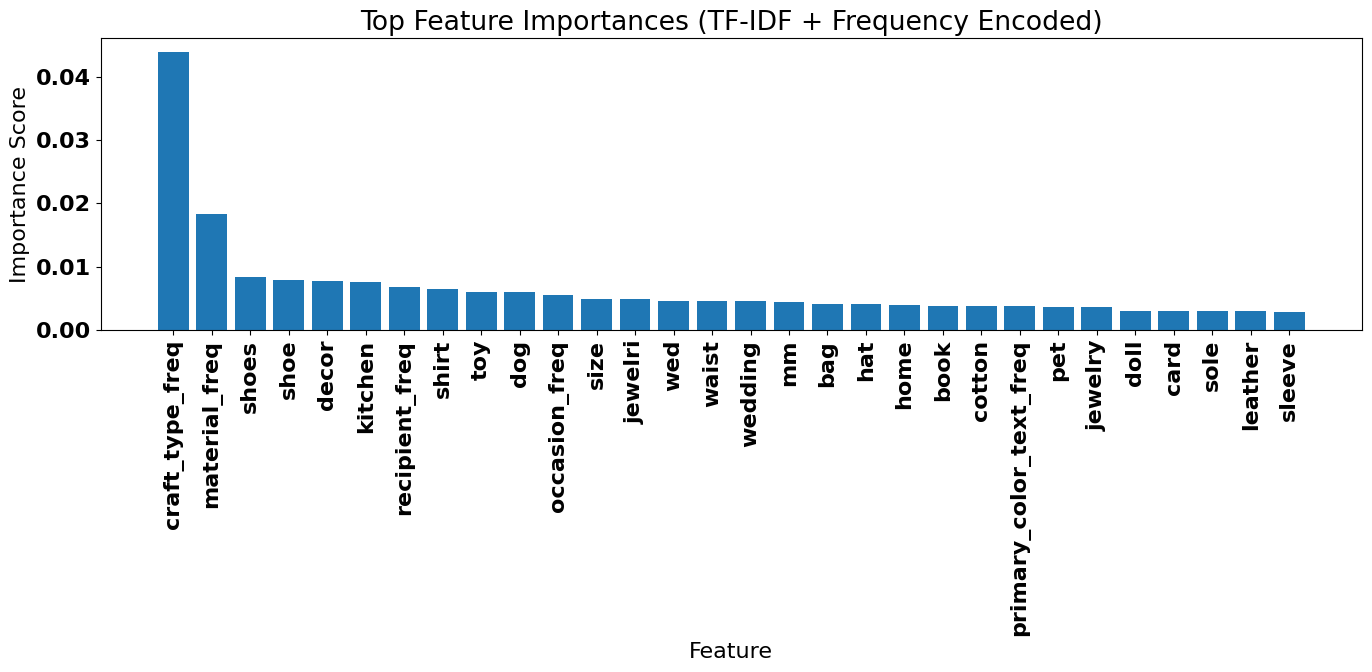

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X = pd.concat([tfidf_df, df_train_top2], axis=1)
X = X.drop(columns=['combined_text', 'top_category_text',
    'bottom_category_text','top_category_id','bottom_category_id'])
y = df_train_top2['top_category_id']

#  Train Random Forest -----
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X, y)

# Feature Importance -----
importances = model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

# Plot Top N Important Features -----
top_n = 30  # adjust this as needed
plt.figure(figsize=(14, 7))
plt.title("Top Feature Importances (TF-IDF + Frequency Encoded)")
plt.bar(range(top_n), importances[indices][:top_n], align='center')
plt.xticks(range(top_n), feature_names[indices][:top_n], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

In [ ]:
tfidf_df.head()

,10,100,11,12,13,14,15,16,17,18,...,write,written,xl,yarn,year,years,yellow,yet,zip,zipper
0,0.102646,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.129787,0.0,0.0,0.0,0.107793,0.118423,0.000000,0.0,0.0,0.0
1,0.000000,0.0,0.000000,0.070179,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,0.000000,0.0,0.143418,0.000000,0.000000,0.0,0.0,0.0,0.0,0.144252,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,0.000000,0.0,0.096592,0.000000,0.104769,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.094077,0.0,0.0,0.0


## ***ML model implementation***

Training until validation scores don't improve for 20 rounds
[50]	valid_0's multi_logloss: 0.74628
[100]	valid_0's multi_logloss: 0.600773
[150]	valid_0's multi_logloss: 0.547101
[200]	valid_0's multi_logloss: 0.52167
[250]	valid_0's multi_logloss: 0.506066
[300]	valid_0's multi_logloss: 0.495495
Did not meet early stopping. Best iteration is:
[300]	valid_0's multi_logloss: 0.495495

Test Accuracy: 0.851235710397387

Classification Report:
 {'0': {'precision': 0.7872062663185379, 'recall': 0.7285541683447443, 'f1-score': 0.7567454507425225, 'support': 2483.0}, '1': {'precision': 0.7370030581039755, 'recall': 0.5530694205393001, 'f1-score': 0.6319239593575877, 'support': 1743.0}, '2': {'precision': 0.8012003000750187, 'recall': 0.8030075187969925, 'f1-score': 0.8021028914757792, 'support': 1330.0}, '3': {'precision': 0.8640915593705293, 'recall': 0.8, 'f1-score': 0.8308115543328748, 'support': 2265.0}, '4': {'precision': 0.8611353711790393, 'recall': 0.7875399361022364, 'f1-score': 0.82

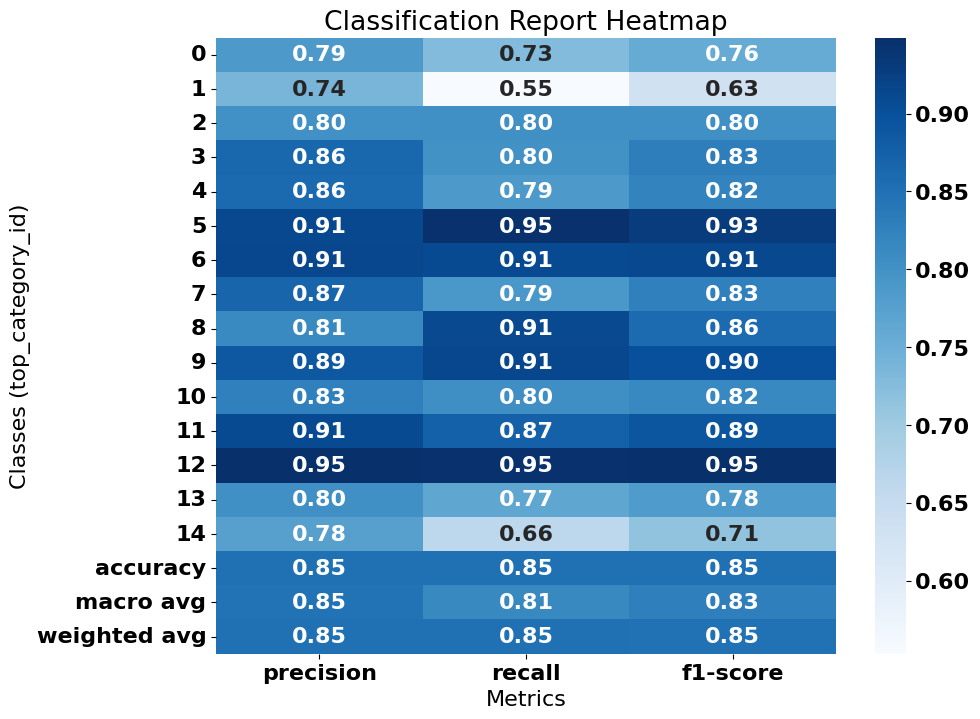

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

X = pd.concat([tfidf_df, df_train_top2], axis=1)
X = X.drop(columns=['combined_text', 'top_category_text',
    'bottom_category_text','top_category_id','bottom_category_id'])
y = df_train_top2['top_category_id']


# ---- Train/Test Split ----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---- Convert to LightGBM Dataset (more memory efficient) ----
train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
test_data = lgb.Dataset(X_test, label=y_test, free_raw_data=False)

# ---- Train Parameters ----
params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y)),  # for classification
    'learning_rate': 0.05,
    'num_leaves': 64,
    'metric': 'multi_logloss',
    'n_jobs': -1,  # full CPU use
    'verbose': -1
}

from lightgbm import early_stopping, log_evaluation

model = lgb.train(
    params,
    train_data,
    valid_sets=[test_data],
    num_boost_round=300,
    callbacks=[
        early_stopping(stopping_rounds=20),
        log_evaluation(50)  # Optional: prints every 50 rounds
    ]
)

# # ---- Train Model ----
# model = lgb.train(
#     params,
#     train_data,
#     valid_sets=[test_data],
#     num_boost_round=300,
#     early_stopping_rounds=20,
#     verbose_eval=50
# )

# ---- Predict and Evaluate ----
y_pred = model.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred_class))


report = classification_report(y_test, y_pred_class, output_dict=True)
print("\nClassification Report:\n", report(y_test, y_pred_class))
# Convert the report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Remove the support column (not needed for visualization)
report_df = report_df.drop(columns=['support'], errors='ignore')

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.boxplot(report_df, annot=True, cmap='Blues', fmt=".2f")
plt.title('Classification Report Heatmap')
plt.xlabel('Metrics')
plt.ylabel('Classes (top_category_id)')
plt.show()


# **Feature Selection for bottom category**


Cramér's V Results:
               Feature  Cramér's V
11                type    0.572075
1           craft_type    0.491972
3             material    0.323976
10  primary_color_text    0.280339
12    primary_color_id    0.280339
5              holiday    0.280316
0                 room    0.273448
2            recipient    0.266402
4             occasion    0.261285
8                shape    0.244748
9              pattern    0.239503
13  secondary_color_id    0.237393
6          art_subject    0.221841
7                style    0.178437

Mutual Information Results:
               Feature  MI Score
1           craft_type  0.615599
12    primary_color_id  0.477441
10  primary_color_text  0.477441
4             occasion  0.447896
13  secondary_color_id  0.385277
3             material  0.376302
5              holiday  0.255850
7                style  0.187248
9              pattern  0.174478
2            recipient  0.164429
0                 room  0.143337
11                type  0.127

<ipython-input-19-678b7e2bacf1>:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Feature", y="MI Score", data=mi_results, palette="viridis")


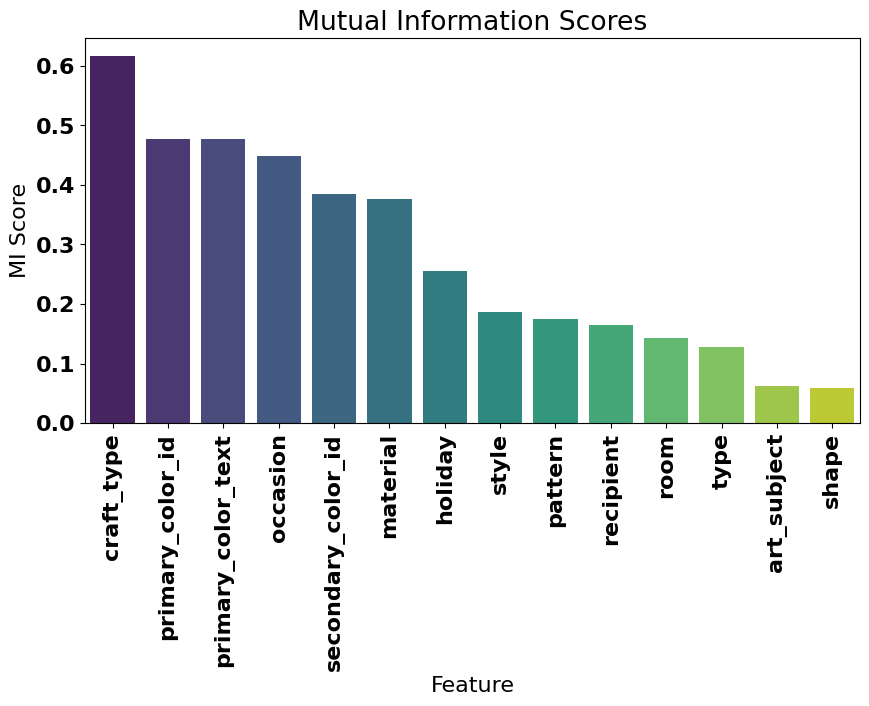

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

# Define categorical features
categorical_features = ["room", "craft_type", "recipient", "material", "occasion",
                        "holiday", "art_subject", "style", "shape", "pattern",
                        "primary_color_text","type","primary_color_id","secondary_color_id"]

                        # "top_category_id"

# Target variable
target = "bottom_category_id"

# Encode target if it's categorical
encoder = LabelEncoder()
df_train_bottom[target] = encoder.fit_transform(df_train[target])

# Encode categorical features
for col in categorical_features:
    df_train_bottom[col] = encoder.fit_transform(df_train_bottom[col])

# ------------------ 1. Cramér's V ------------------
def cramers_v(x, y):
    """ Compute Cramér's V for categorical variables """
    confusion_matrix = pd.crosstab(x, y)
    chi2_stat = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2_stat / (n * (min(r, k) - 1)))

# Compute Cramér's V for each categorical feature
cramers_results = {col: cramers_v(df_train_bottom[col], df_train_bottom[target]) for col in categorical_features}
cramers_df = pd.DataFrame(cramers_results.items(), columns=["Feature", "Cramér's V"])
cramers_df.sort_values(by="Cramér's V", ascending=False, inplace=True)

print("\nCramér's V Results:")
print(cramers_df)

# ------------------ 2. Mutual Information (MI) ------------------
mi_scores = mutual_info_classif(df_train_bottom[categorical_features], df_train_bottom[target], discrete_features=True)
mi_results = pd.DataFrame({"Feature": categorical_features, "MI Score": mi_scores})
mi_results.sort_values(by="MI Score", ascending=False, inplace=True)

print("\nMutual Information Results:")
print(mi_results)

# ------------------ 3. Visualization ------------------
plt.figure(figsize=(10, 5))
sns.barplot(x="Feature", y="MI Score", data=mi_results, palette="viridis")
plt.xticks(rotation=90)
plt.title("Mutual Information Scores")
plt.show()

## **Dropping Unwanted Columns**

In [ ]:
columns_to_drop = ['product_id', 'type', 'room', 'art_subject', 'shape', 'primary_color_text', 'secondary_color_text',"pattern"]
df_train_bottom = df_train_bottom.drop(columns=columns_to_drop, errors='ignore')

In [ ]:
df_train_bottom.head()

,title,description,tags,craft_type,recipient,material,occasion,holiday,style,bottom_category_id,bottom_category_text,top_category_id,top_category_text,primary_color_id,secondary_color_id
0,Children&#39;s circle skirt BLUE GALAXY made o...,The fuxandfriends children&#39;s full circle s...,,,,,,,,426,clothing.girls_clothing.skirts,5,clothing,2,2
1,"Cow Birthday Tutu for kids, Farm Theme Bday Ou...",💄This listing is for the TUTU ONLY (double rib...,"birthday outfit,girls birthday shirt,Tutu outf...",,,,birthday,,,426,clothing.girls_clothing.skirts,5,clothing,11,1
2,"Zebra print tutu, animal print Skirt, World bo...",All tutus are handmade to order with two layer...,"black and white tutu,striped skirt,zebra tutu,...",,,,,,,426,clothing.girls_clothing.skirts,5,clothing,17,1
3,"Lilac Tutu Rainbow Dots // Girl&#39;s Tutu, Tu...",Step aside because the princess pop star is he...,"tutu,girls skirt,sparkling tutu,fun skirt,ball...",,,,birthday,christmas,,426,clothing.girls_clothing.skirts,5,clothing,12,13
4,Bumblebee tutu yellow and black tutu halloween...,"Sparkle, shimmer, twirl and spin,\nThis tutu&#...","dog tutu,fluffy tutu,dance tutu,skirt,flower g...",,,,birthday,halloween,,426,clothing.girls_clothing.skirts,5,clothing,18,1


In [ ]:
pd.set_option('display.max_columns', None)
df_train_bottom2.head()

,product_id,title,description,tags,type,room,craft_type,recipient,material,occasion,holiday,art_subject,style,shape,pattern,bottom_category_id,bottom_category_text,top_category_id,top_category_text,primary_color_id,primary_color_text,secondary_color_id,secondary_color_text,combined_text,title_cleaned,title_lemmatized,title_stemmed,tags_cleaned,tags_lemmatized,tags_stemmed,description_cleaned,description_lemmatized,description_stemmed,combined_text_cleaned,combined_text_lemmatized,combined_text_stemmed
0,699437355,Children&#39;s circle skirt BLUE GALAXY made o...,The fuxandfriends children&#39;s full circle s...,,physical,,,,,,,,,,,426,clothing.girls_clothing.skirts,5,clothing,2,blue,2,blue,Children&#39;s circle skirt BLUE GALAXY made o...,children 39 circle skirt blue galaxy made ligh...,child 39 circle skirt blue galaxy make light s...,children 39 circl skirt blue galaxi made light...,,,,fuxandfriends children 39 full circle skirt ex...,fuxandfriend child 39 full circle skirt exhila...,fuxandfriend children 39 full circl skirt exhi...,children 39 circle skirt blue galaxy made ligh...,child 39 circle skirt blue galaxy make light s...,children 39 circl skirt blue galaxi made light...
1,1323699538,"Cow Birthday Tutu for kids, Farm Theme Bday Ou...",💄This listing is for the TUTU ONLY (double rib...,"birthday outfit,girls birthday shirt,Tutu outf...",physical,,,,,birthday,,,,,animal print,426,clothing.girls_clothing.skirts,5,clothing,11,pink,1,black,"Cow Birthday Tutu for kids, Farm Theme Bday Ou...",cow birthday tutu kids farm theme bday outfit ...,cow birthday tutu kid farm theme bday outfit p...,cow birthday tutu kid farm theme bday outfit p...,birthday outfit girls birthday shirt tutu outf...,birthday outfit girl birthday shirt tutu outfi...,birthday outfit girl birthday shirt tutu outfi...,listing tutu double ribbion include shirt prop...,list tutu double ribbion include shirt prop he...,list tutu doubl ribbion includ shirt prop head...,cow birthday tutu kids farm theme bday outfit ...,cow birthday tutu kid farm theme bday outfit p...,cow birthday tutu kid farm theme bday outfit p...
2,1142910558,"Zebra print tutu, animal print Skirt, World bo...",All tutus are handmade to order with two layer...,"black and white tutu,striped skirt,zebra tutu,...",physical,,,,,,,,,,animal print,426,clothing.girls_clothing.skirts,5,clothing,17,white,1,black,"Zebra print tutu, animal Skirt, World book day...",zebra print tutu animal print skirt world book...,zebra print tutu animal print skirt world book...,zebra print tutu anim print skirt world book d...,black white tutu striped skirt zebra tutu safa...,black white tutu stripe skirt zebra tutu safar...,black white tutu stripe skirt zebra tutu safar...,tutus handmade order two layers tulle strip fa...,tutus handmade order two layer tulle strip fab...,tutu handmad order two layer tull strip fabric...,zebra print tutu animal skirt world book day c...,zebra print tutu animal skirt world book day c...,zebra print tutu anim skirt world book day cos...
3,1320296928,"Lilac Tutu Rainbow Dots // Girl&#39;s Tutu, Tu...",Step aside because the princess pop star is he...,"tutu,girls skirt,sparkling tutu,fun skirt,ball...",physical,,,,,birthday,christmas,,,,,426,clothing.girls_clothing.skirts,5,clothing,12,purple,13,rainbow,"Lilac Tutu Rainbow Dots // Girl&#39;s Tutu, Tu...",lilac tutu rainbow dots girl 39 tutu tulle ski...,lilac tutu rainbow dot girl 39 tutu tulle skir...,lilac tutu rainbow dot girl 39 tutu tull skirt...,tutu girls skirt sparkling tutu fun skirt ball...,tutu girls skirt sparkle tutu fun skirt ballet...,tutu girl skirt sparkl tutu fun skirt ballet t...,step aside princess pop star win hearts made h...,step aside princess pop star win heart make hi...,step asid princess pop star win heart made hig...,lilac tutu rainbow dots girl 39 tutu tulle ski...,lilac tutu rainbow dot girl 39 tutu tulle skir...,lilac tutu rainbow dot girl 39 tutu tull skirt...
4,854901795,Bumblebee tutu yellow and black

## ***MultiThreading- Preprocessing for text based columns***

In [ ]:
# CA684 Machine Learning Assignment Spring 2024
# ... (rest of your previous code) ...

# **Applying Pre-Processng techniques on text based columns**
# ***Title - column***
# ... (MCq 25 questions and 1/3 negative marking comment) ...
import pandas as pd
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import concurrent.futures

# Load resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
nlp = spacy.load("en_core_web_sm")

# Function to preprocess text
def preprocess_text(text):
    if pd.isna(text):
        return ""

    text = text.lower()  # Lowercase
    tokens = nltk.word_tokenize(text)  # Tokenize

    # Remove stopwords
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]

    # Lemmatization with spaCy
    doc = nlp(" ".join(filtered_tokens))
    lemmatized = [token.lemma_ for token in doc]

    # Stemming with NLTK
    stemmed = [stemmer.stem(word) for word in filtered_tokens]

    return {
        "cleaned": " ".join(filtered_tokens),
        "lemmatized": " ".join(lemmatized),
        "stemmed": " ".join(stemmed)
    }

# Apply preprocessing using multithreading
def process_column(col):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(preprocess_text, df_train_bottom[col]))

    df_train_bottom[f"{col}_cleaned"] = [r['cleaned'] for r in results]
    df_train_bottom[f"{col}_lemmatized"] = [r['lemmatized'] for r in results]
    df_train_bottom[f"{col}_stemmed"] = [r['stemmed'] for r in results]

# Process each text column in parallel
with concurrent.futures.ThreadPoolExecutor() as executor:
    executor.map(process_column, ['combined_text'])

print("Done Pre Processing , now saving the file")

import os

save_path = "/content/gdrive/MyDrive/machine_Learning_Assig/train_preProcessed_bottom"
os.makedirs(save_path, exist_ok=True)  # Create the folder if it doesn't exist

# Save as parquet
df_train_bottom.to_parquet(os.path.join(save_path, "train_preprocessed.parquet"), index=False)

# Save as CSV
df_train_bottom.to_csv(os.path.join(save_path, "train_preprocessed.csv"), index=False)

# Save as XLSX (might take longer for large datasets)
# df_train_bottom.to_excel(os.path.join(save_path, "train_preprocessed.xlsx"), index=False)

print("Processed DataFrame saved successfully!")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Done Pre Processing , now saving the file
Processed DataFrame saved successfully!


## ***New DataFrame for PreProceesed***

In [16]:
df_train_bottom2 = pd.read_parquet(f"/content/gdrive/MyDrive/machine_Learning_Assig/train_preProcessed_bottom")

In [ ]:
df_train_bottom2.head()

,product_id,title,description,tags,type,room,craft_type,recipient,material,occasion,...,title_stemmed,tags_cleaned,tags_lemmatized,tags_stemmed,description_cleaned,description_lemmatized,description_stemmed,combined_text_cleaned,combined_text_lemmatized,combined_text_stemmed
0,699437355,Children&#39;s circle skirt BLUE GALAXY made o...,The fuxandfriends children&#39;s full circle s...,,physical,,,,,,...,children 39 circl skirt blue galaxi made light...,,,,fuxandfriends children 39 full circle skirt ex...,fuxandfriend child 39 full circle skirt exhila...,fuxandfriend children 39 full circl skirt exhi...,children 39 circle skirt blue galaxy made ligh...,child 39 circle skirt blue galaxy make light s...,children 39 circl skirt blue galaxi made light...
1,1323699538,"Cow Birthday Tutu for kids, Farm Theme Bday Ou...",💄This listing is for the TUTU ONLY (double rib...,"birthday outfit,girls birthday shirt,Tutu outf...",physical,,,,,birthday,...,cow birthday tutu kid farm theme bday outfit p...,birthday outfit girls birthday shirt tutu outf...,birthday outfit girl birthday shirt tutu outfi...,birthday outfit girl birthday shirt tutu outfi...,listing tutu double ribbion include shirt prop...,list tutu double ribbion include shirt prop he...,list tutu doubl ribbion includ shirt prop head...,cow birthday tutu kids farm theme bday outfit ...,cow birthday tutu kid farm theme bday outfit p...,cow birthday tutu kid farm theme bday outfit p...
2,1142910558,"Zebra print tutu, animal print Skirt, World bo...",All tutus are handmade to order with two layer...,"black and white tutu,striped skirt,zebra tutu,...",physical,,,,,,...,zebra print tutu anim print skirt world book d...,black white tutu striped skirt zebra tutu safa...,black white tutu stripe skirt zebra tutu safar...,black white tutu stripe skirt zebra tutu safar...,tutus handmade order two layers tulle strip fa...,tutus handmade order two layer tulle strip fab...,tutu handmad order two layer tull strip fabric...,zebra print tutu animal skirt world book day c...,zebra print tutu animal skirt world book day c...,zebra print tutu anim skirt world book day cos...
3,1320296928,"Lilac Tutu Rainbow Dots // Girl&#39;s Tutu, Tu...",Step aside because the princess pop star is he...,"tutu,girls skirt,sparkling tutu,fun skirt,ball...",physical,,,,,birthday,...,lilac tutu rainbow dot girl 39 tutu tull skirt...,tutu girls skirt sparkling tutu fun skirt ball...,tutu girls skirt sparkle tutu fun skirt ballet...,tutu girl skirt sparkl tutu fun skirt ballet t...,step aside princess pop star win hearts made h...,step aside princess pop star win heart make hi...,step asid princess pop star win heart made hig...,lilac tutu rainbow dots girl 39 tutu tulle ski...,lilac tutu rainbow dot girl 39 tutu tulle skir...,lilac tutu rainbow dot girl 39 tutu tull skirt...
4,854901795,Bumblebee tutu yellow and black tutu halloween...,"Sparkle, shimmer, twirl and spin,\nThis tutu&#...","dog tutu,fluffy tutu,dance tutu,skirt,flower g...",physical,,,,,birthday,...,bumblebe tutu yellow black tutu halloween tutu...,dog tutu fluffy tutu dance tutu skirt flower g...,dog tutu fluffy tutu dance tutu skirt flower g...,dog tutu fluffi tutu danc tutu skirt flower gi...,sparkle shimmer twirl spin tutu 39 fun begins ...,sparkle shimmer twirl spin tutu 39 fun begin d...,sparkl shimmer twirl spin tutu 39 fun begin dr...,bumblebee tutu yellow black halloween kids tod...,bumblebee tutu yellow black halloween kid todd...,bumblebe tutu yellow black halloween kid toddl...


## ***Merged Text Based Columns into one column***

In [13]:
from multiprocessing import Pool, cpu_count
# Define a helper function that removes duplicate words while preserving their first occurrence.
def remove_duplicates(text):
    seen = set()
    result = []
    for word in text.split():
        if word not in seen:
            seen.add(word)
            result.append(word)
    return " ".join(result)

# Define a function that takes in a row (as an array of strings from the text columns),
# concatenates the fields, and removes duplicate words.
def combine_and_clean(row):
    text = ' '.join(row)  # combine text from multiple columns
    return remove_duplicates(text)

# Specify the text columns to combine.
text_features =['combined_text','title_cleaned','title_lemmatized','title_stemmed','tags_cleaned','tags_lemmatized','tags_stemmed','description_cleaned'
,'description_lemmatized','description_stemmed','combined_text_cleaned','combined_text_lemmatized','combined_text_stemmed','bottom_category_text']

# Convert the text_features columns to a numpy array where each row is a list of strings.
text_data = df_train_bottom2[text_features].values

# Use multiprocessing to apply combine_and_clean in parallel.
with Pool(cpu_count()) as pool:
    combined_text = pool.map(combine_and_clean, text_data)

# Add the new column to the dataframe.
df_train_bottom2['combined_text'] = combined_text


In [ ]:
# Download the DataFrame to a CSV file
from google.colab import files
df_train_bottom2.to_csv('bottom_categories_processed.csv', encoding = 'utf-8-sig', index=False)
files.download('bottom_categories_processed.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## ***Removing Text Based columns after merging***

In [17]:
columns_to_drop = ['title_cleaned','title_lemmatized','title_stemmed','tags_cleaned','tags_lemmatized','tags_stemmed','description_cleaned'
,'description_lemmatized','description_stemmed','combined_text_cleaned','combined_text_lemmatized','combined_text_stemmed','art_subject','shape','product_id']

df_train_bottom2 = df_train_bottom2.drop(columns=columns_to_drop, errors='ignore')

In [21]:
columns_to_drop = ['description','tags','type','room','top_category_text','primary_color_text','type','room','secondary_color_text','style','pattern']
df_train_bottom2 = df_train_bottom2.drop(columns=columns_to_drop, errors='ignore')

In [23]:
df_train_bottom2.head()

,title,bottom_category_id,bottom_category_text,top_category_id,primary_color_id,secondary_color_id,combined_text,craft_type_freq,recipient_freq,material_freq,occasion_freq,holiday_freq
0,Children&#39;s circle skirt BLUE GALAXY made o...,426,clothing.girls_clothing.skirts,5,2,2,Children&#39;s circle skirt BLUE GALAXY made o...,0.879098,0.952927,0.911856,0.747091,0.798518
1,"Cow Birthday Tutu for kids, Farm Theme Bday Ou...",426,clothing.girls_clothing.skirts,5,11,1,"Cow Birthday Tutu for kids, Farm Theme Bday Ou...",0.879098,0.952927,0.911856,0.090574,0.798518
2,"Zebra print tutu, animal print Skirt, World bo...",426,clothing.girls_clothing.skirts,5,17,1,"Zebra print tutu, animal Skirt, World book day...",0.879098,0.952927,0.911856,0.747091,0.798518
3,"Lilac Tutu Rainbow Dots // Girl&#39;s Tutu, Tu...",426,clothing.girls_clothing.skirts,5,12,13,"Lilac Tutu Rainbow Dots // Girl&#39;s Tutu, Tu...",0.879098,0.952927,0.911856,0.090574,0.098962
4,Bumblebee tutu yellow and black tutu halloween...,426,clothing.girls_clothing.skirts,5,18,1,Bumblebee tutu yellow and black halloween kids...,0.879098,0.952927,0.911856,0.090574,0.017925


## ***Applying Frequency Encoding for Categorical columns- due to high cardinality ***

In [ ]:
import pandas as pd

# Assuming df is your dataframe
high_card_cols = [
    'craft_type',
    'recipient',
    'material',
    'occasion',
    'holiday'
]

# Apply frequency encoding
for col in high_card_cols:
    freq_map = df_train_bottom2[col].value_counts(normalize=True)
    df_train_bottom2[col + '_freq'] = df_train_bottom2[col].map(freq_map)

# Drop original high-cardinality columns if you don't want them anymore
df_train_bottom2.drop(columns=high_card_cols, inplace=True)


## ***TFIDF- Application for text based columns***

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming df['combined_text'] already exists
# Limit max_features to reduce dimensionality and improve performance
tfidf = TfidfVectorizer(max_features=2000)  # You can increase/decrease this based on RAM

# Fit and transform the text column
X_tfidf = tfidf.fit_transform(df_train_bottom2['combined_text'])

# To see the feature names (words)
feature_names = tfidf.get_feature_names_out()

# Optional: convert to DataFrame if needed
import pandas as pd
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=feature_names)

# You can now use tfidf_df with your ML model along with other features


In [25]:
df_train_bottom2.head()

,title,bottom_category_id,bottom_category_text,top_category_id,primary_color_id,secondary_color_id,combined_text,craft_type_freq,recipient_freq,material_freq,occasion_freq,holiday_freq
0,Children&#39;s circle skirt BLUE GALAXY made o...,426,clothing.girls_clothing.skirts,5,2,2,Children&#39;s circle skirt BLUE GALAXY made o...,0.879098,0.952927,0.911856,0.747091,0.798518
1,"Cow Birthday Tutu for kids, Farm Theme Bday Ou...",426,clothing.girls_clothing.skirts,5,11,1,"Cow Birthday Tutu for kids, Farm Theme Bday Ou...",0.879098,0.952927,0.911856,0.090574,0.798518
2,"Zebra print tutu, animal print Skirt, World bo...",426,clothing.girls_clothing.skirts,5,17,1,"Zebra print tutu, animal Skirt, World book day...",0.879098,0.952927,0.911856,0.747091,0.798518
3,"Lilac Tutu Rainbow Dots // Girl&#39;s Tutu, Tu...",426,clothing.girls_clothing.skirts,5,12,13,"Lilac Tutu Rainbow Dots // Girl&#39;s Tutu, Tu...",0.879098,0.952927,0.911856,0.090574,0.098962
4,Bumblebee tutu yellow and black tutu halloween...,426,clothing.girls_clothing.skirts,5,18,1,Bumblebee tutu yellow and black halloween kids...,0.879098,0.952927,0.911856,0.090574,0.017925


## ***Cleaning bottom category id column***

In [26]:
# prompt: perform trim on bottom category id and extract strings if any and replace blank values with 0
# download the dataframe in a csv format

import pandas as pd
# Assuming df_train_bottom2 is your DataFrame
# Trim the bottom_category_id column (assuming it's numeric)
df_train_bottom2['bottom_category_id'] = df_train_bottom2['bottom_category_id'].astype(str).str.strip()

# Extract string parts if any (e.g., if it had extra characters)
# and convert to numeric, coercing errors to NaN. Then fill NaN with 0.
df_train_bottom2['bottom_category_id'] = pd.to_numeric(df_train_bottom2['bottom_category_id'], errors='coerce').fillna(0).astype(int)


# # Download the DataFrame to a CSV file
# from google.colab import files
# df_train_bottom2.to_csv('bottom_categories_processed.csv', encoding = 'utf-8-sig', index=False)
# files.download('bottom_categories_processed.csv')


## ***Feature Importance***

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X = pd.concat([tfidf_df, df_train_bottom2], axis=1)
X = X.drop(columns=['combined_text', 'top_category_text',
    'bottom_category_text','top_category_text','primary_color_text','type','room','secondary_color_text'])
y = df_train_bottom2['bottom_category_id']

#  Train Random Forest -----
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X, y)

# Feature Importance -----
importances = model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

# Plot Top N Important Features -----
top_n = 30  # adjust this as needed
plt.figure(figsize=(14, 7))
plt.title("Top Feature Importances (TF-IDF + Frequency Encoded)")
plt.bar(range(top_n), importances[indices][:top_n], align='center')
plt.xticks(range(top_n), feature_names[indices][:top_n], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

## ***ML model implementation***

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 11.7072

Test Accuracy: 0.5008818726183996

Classification Report:
               precision    recall  f1-score   support

           1       0.40      0.11      0.17        18
           2       0.55      0.32      0.40        19
           3       0.86      0.71      0.77        17
           4       0.53      0.56      0.54        18
           5       0.93      0.68      0.79        19
           6       0.22      0.11      0.15        18
           7       0.70      0.41      0.52        17
           8       0.93      0.78      0.85        18
           9       0.78      0.39      0.52        18
          10       0.60      0.50      0.55        18
          11       1.00      0.67      0.80        18
          12       0.94      0.83      0.88        18
          13       0.74      0.78      0.76        18
          14       0.86      0.63      0.73       

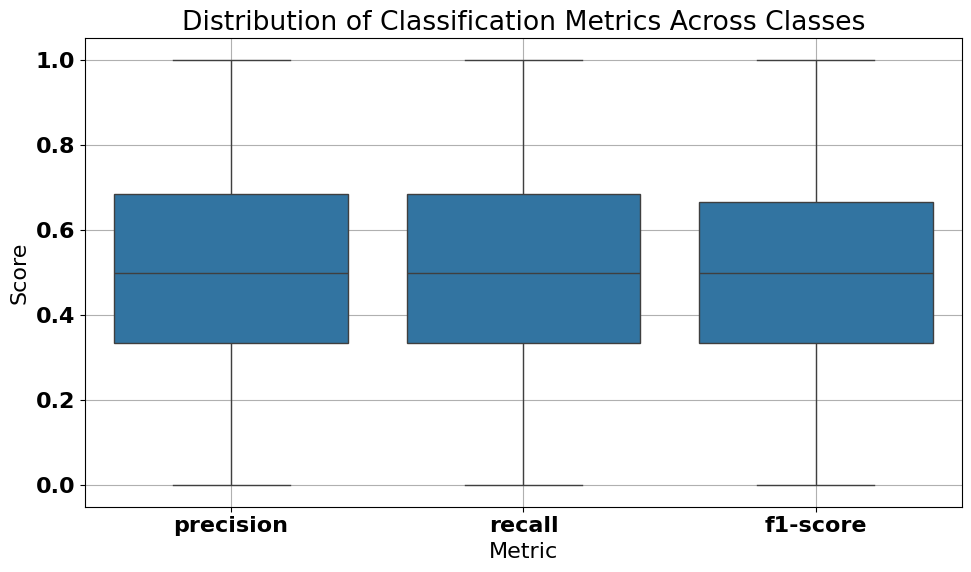

In [28]:
#  Install
!pip install lightgbm --quiet

#  Imports
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack
import seaborn as sns
import matplotlib.pyplot as plt

#  Step 1: Prepare Features and Target
X = pd.concat([tfidf_df, df_train_bottom2], axis=1)

# Drop irrelevant columns
X = X.drop(columns=[
   'combined_text','bottom_category_text','title'
])
# , 'top_category_text',
#     'bottom_category_text','top_category_text','primary_color_text','type','room','secondary_color_text'

#  Step 2: Label Encode Target (bottom_category_id)
le = LabelEncoder()
y = le.fit_transform(df_train_bottom2['bottom_category_id'])  # encoded target

#  Step 3: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#  Step 4: LightGBM Dataset
train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
test_data = lgb.Dataset(X_test, label=y_test, free_raw_data=False)

#  Step 5: LightGBM Parameters
params = {
    'objective': 'multiclass',
    'num_class': len(le.classes_),
    'learning_rate': 0.05,
    'num_leaves': 64,
    'metric': 'multi_logloss',
    'n_jobs': -1,
    'verbose': -1
}

from lightgbm import early_stopping, log_evaluation

#  Step 6: Train the Model
model = lgb.train(
    params,
    train_data,
    valid_sets=[test_data],
    num_boost_round=300,
    callbacks=[
        early_stopping(stopping_rounds=20),
        log_evaluation(50)
    ]
)

#  Step 7: Predict and Evaluate
y_pred = model.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)

# Decode predictions and true labels back to original category IDs
y_test_decoded = le.inverse_transform(y_test)
y_pred_decoded = le.inverse_transform(y_pred_class)

print("\nTest Accuracy:", accuracy_score(y_test_decoded, y_pred_decoded))

# Classification report
report = classification_report(y_test_decoded, y_pred_decoded, output_dict=True)
print("\nClassification Report:\n", classification_report(y_test_decoded, y_pred_decoded))

#  Step 8: Visualization
report_df = pd.DataFrame(report).transpose()

# Keep only class-level rows (filter out 'accuracy', 'macro avg', etc.)
class_metrics = report_df[report_df.index.str.isnumeric()]

# Reshape for seaborn boxplot
melted = class_metrics[['precision', 'recall', 'f1-score']].reset_index().melt(id_vars='index')
melted.columns = ['class_id', 'metric', 'score']

# Plot boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='metric', y='score', data=melted)
plt.title('Distribution of Classification Metrics Across Classes')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
!pip install -U sentence-transformers --quiet

# ***Preparing test dataset***

In [32]:
df_test_bottom= read_data("test", parquet_filenames_test)


In [30]:
df_test_top = read_data("test", parquet_filenames_test)

In [31]:
df_test_top.head()

,product_id,title,description,tags,type,room,craft_type,recipient,material,occasion,holiday,art_subject,style,shape,pattern
0,661373440,"Classroom Valentine Favors, Valentine Pencils,...","Valentine Favors, Robots of Love Vinyl Pencil ...","Valentines day favor,kindergarten treats,valen...",physical,,kids' crafts,,,,valentine's day,,,,
1,1501009290,5 Colour Slatepencils In One Pack Order NOw,5 Colour Slatepencils In One Pack Order NOw\n\...,"slatepencils,clay,nakumatt,edibleclay",physical,,drawing & drafting,,,,,,,,
2,1105447030,"No 2 Pencils by Associated Commercial, #2 Wri...","This listing is for a dozen, unused pre sharpe...","Faber Castell,aw faber,Faber-Castell,antique p...",physical,,drawing & drafting,,,,,,,,
3,1140081090,"Personalized Carpenter Pencils, Engraved Carpe...",EtchThisOut is now offering Carpenter Pencils ...,"Personalized Pencils,Carpenter Pencils,Carpent...",physical,,drawing & drafting,,,birthday,valentine's day,,,,
4,793448890,Vintage 1960&#39;s Autopoint mechanical pencil...,Vintage 1950&#39;s Autopoint mechanical pencil...,"Mechanical pencil,Autopoint pencil,Drafting pe...",physical,,calligraphy,,,,,,,,


In [39]:
df_test_bottom.head()

,title,description,tags,craft_type,recipient,material,occasion,holiday,style,combined_text
0,"Classroom Valentine Favors, Valentine Pencils,...","Valentine Favors, Robots of Love Vinyl Pencil ...","Valentines day favor,kindergarten treats,valen...",kids' crafts,,,,valentine's day,,"Classroom Valentine Favors, Pencils, Valentine..."
1,5 Colour Slatepencils In One Pack Order NOw,5 Colour Slatepencils In One Pack Order NOw\n\...,"slatepencils,clay,nakumatt,edibleclay",drawing & drafting,,,,,,5 Colour Slatepencils In One Pack Order NOw sl...
2,"No 2 Pencils by Associated Commercial, #2 Wri...","This listing is for a dozen, unused pre sharpe...","Faber Castell,aw faber,Faber-Castell,antique p...",drawing & drafting,,,,,,"No 2 Pencils by Associated Commercial, #2 Writ..."
3,"Personalized Carpenter Pencils, Engraved Carpe...",EtchThisOut is now offering Carpenter Pencils ...,"Personalized Pencils,Carpenter Pencils,Carpent...",drawing & drafting,,,birthday,valentine's day,,"Personalized Carpenter Pencils, Engraved Gifts..."
4,Vintage 1960&#39;s Autopoint mechanical pencil...,Vintage 1950&#39;s Autopoint mechanical pencil...,"Mechanical pencil,Autopoint pencil,Drafting pe...",calligraphy,,,,,,Vintage 1960&#39;s Autopoint mechanical pencil...


## ***Merged text based Columns in Test dataset***

In [33]:
from multiprocessing import Pool, cpu_count
# Define a helper function that removes duplicate words while preserving their first occurrence.
def remove_duplicates(text):
    seen = set()
    result = []
    for word in text.split():
        if word not in seen:
            seen.add(word)
            result.append(word)
    return " ".join(result)

# Define a function that takes in a row (as an array of strings from the text columns),
# concatenates the fields, and removes duplicate words.
def combine_and_clean(row):
    text = ' '.join(row)  # combine text from multiple columns
    return remove_duplicates(text)

# Specify the text columns to combine.
text_features =['title','tags','description','style','shape','pattern']

# Convert the text_features columns to a numpy array where each row is a list of strings.
text_data = df_test_bottom[text_features].values

# Use multiprocessing to apply combine_and_clean in parallel.
with Pool(cpu_count()) as pool:
    combined_text = pool.map(combine_and_clean, text_data)

text_data = df_test_top[text_features].values

# Use multiprocessing to apply combine_and_clean in parallel.
with Pool(cpu_count()) as pool:
    combined_text = pool.map(combine_and_clean, text_data)

df_test_top['combined_text'] = combined_text
# Add the new column to the dataframe.
df_test_bottom['combined_text'] = combined_text

## ***Remove unwanted columns***

In [40]:
columns_to_drop = [ 'type', 'room', 'art_subject', 'shape', 'secondary_color_text','pattern','style']
columns_to_drop_bottom = [ 'type', 'room', 'art_subject', 'shape', 'secondary_color_text','pattern','style','recipient']
df_test_bottom = df_test_bottom.drop(columns=columns_to_drop_bottom, errors='ignore')
df_test_top = df_test_top.drop(columns=columns_to_drop, errors='ignore')

In [38]:
df_test_top.head()

,product_id,title,description,tags,craft_type,recipient,material,occasion,holiday,combined_text
0,661373440,"Classroom Valentine Favors, Valentine Pencils,...","Valentine Favors, Robots of Love Vinyl Pencil ...","Valentines day favor,kindergarten treats,valen...",kids' crafts,,,,valentine's day,"Classroom Valentine Favors, Pencils, Valentine..."
1,1501009290,5 Colour Slatepencils In One Pack Order NOw,5 Colour Slatepencils In One Pack Order NOw\n\...,"slatepencils,clay,nakumatt,edibleclay",drawing & drafting,,,,,5 Colour Slatepencils In One Pack Order NOw sl...
2,1105447030,"No 2 Pencils by Associated Commercial, #2 Wri...","This listing is for a dozen, unused pre sharpe...","Faber Castell,aw faber,Faber-Castell,antique p...",drawing & drafting,,,,,"No 2 Pencils by Associated Commercial, #2 Writ..."
3,1140081090,"Personalized Carpenter Pencils, Engraved Carpe...",EtchThisOut is now offering Carpenter Pencils ...,"Personalized Pencils,Carpenter Pencils,Carpent...",drawing & drafting,,,birthday,valentine's day,"Personalized Carpenter Pencils, Engraved Gifts..."
4,793448890,Vintage 1960&#39;s Autopoint mechanical pencil...,Vintage 1950&#39;s Autopoint mechanical pencil...,"Mechanical pencil,Autopoint pencil,Drafting pe...",calligraphy,,,,,Vintage 1960&#39;s Autopoint mechanical pencil...


In [39]:
df_test_bottom.head()

,product_id,title,description,tags,craft_type,recipient,material,occasion,holiday,combined_text
0,661373440,"Classroom Valentine Favors, Valentine Pencils,...","Valentine Favors, Robots of Love Vinyl Pencil ...","Valentines day favor,kindergarten treats,valen...",kids' crafts,,,,valentine's day,"Classroom Valentine Favors, Pencils, Valentine..."
1,1501009290,5 Colour Slatepencils In One Pack Order NOw,5 Colour Slatepencils In One Pack Order NOw\n\...,"slatepencils,clay,nakumatt,edibleclay",drawing & drafting,,,,,5 Colour Slatepencils In One Pack Order NOw sl...
2,1105447030,"No 2 Pencils by Associated Commercial, #2 Wri...","This listing is for a dozen, unused pre sharpe...","Faber Castell,aw faber,Faber-Castell,antique p...",drawing & drafting,,,,,"No 2 Pencils by Associated Commercial, #2 Writ..."
3,1140081090,"Personalized Carpenter Pencils, Engraved Carpe...",EtchThisOut is now offering Carpenter Pencils ...,"Personalized Pencils,Carpenter Pencils,Carpent...",drawing & drafting,,,birthday,valentine's day,"Personalized Carpenter Pencils, Engraved Gifts..."
4,793448890,Vintage 1960&#39;s Autopoint mechanical pencil...,Vintage 1950&#39;s Autopoint mechanical pencil...,"Mechanical pencil,Autopoint pencil,Drafting pe...",calligraphy,,,,,Vintage 1960&#39;s Autopoint mechanical pencil...


In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming df['combined_text'] already exists
# Limit max_features to reduce dimensionality and improve performance
tfidf = TfidfVectorizer(max_features=2000)  # You can increase/decrease this based on RAM

# Fit and transform the text column
X_tfidf = tfidf.fit_transform(df_test_bottom['combined_text'])

# To see the feature names (words)
feature_names = tfidf.get_feature_names_out()

# Optional: convert to DataFrame if needed
import pandas as pd
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=feature_names)

# You can now use tfidf_df with your ML model along with other features



## ***MultiTHreading - Preprocessing - Test Dataset - Top***

In [ ]:
# CA684 Machine Learning Assignment Spring 2024
# ... (rest of your previous code) ...

# **Applying Pre-Processng techniques on text based columns**
# ***Title - column***
# ... (MCq 25 questions and 1/3 negative marking comment) ...
import pandas as pd
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import concurrent.futures

# Load resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
nlp = spacy.load("en_core_web_sm")

# Function to preprocess text
def preprocess_text(text):
    if pd.isna(text):
        return ""

    text = text.lower()  # Lowercase
    tokens = nltk.word_tokenize(text)  # Tokenize

    # Remove stopwords
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]

    # Lemmatization with spaCy
    doc = nlp(" ".join(filtered_tokens))
    lemmatized = [token.lemma_ for token in doc]

    # Stemming with NLTK
    stemmed = [stemmer.stem(word) for word in filtered_tokens]

    return {
        "cleaned": " ".join(filtered_tokens),
        "lemmatized": " ".join(lemmatized),
        "stemmed": " ".join(stemmed)
    }

# Apply preprocessing using multithreading
def process_column(col):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(preprocess_text, df_test_bottom[col]))

    df_test_bottom[f"{col}_cleaned"] = [r['cleaned'] for r in results]
    df_test_bottom[f"{col}_lemmatized"] = [r['lemmatized'] for r in results]
    df_test_bottom[f"{col}_stemmed"] = [r['stemmed'] for r in results]

# Process each text column in parallel
with concurrent.futures.ThreadPoolExecutor() as executor:
    executor.map(process_column, ['combined_text'])

print("Done Pre Processing , now saving the file")

import os

save_path = "/content/gdrive/MyDrive/machine_Learning_Assig/test_preProcessed_bottom"
os.makedirs(save_path, exist_ok=True)  # Create the folder if it doesn't exist

# Save as parquet
df_test_bottom.to_parquet(os.path.join(save_path, "test_preprocessed.parquet"), index=False)

# Save as CSV
df_test_bottom.to_csv(os.path.join(save_path, "test_preprocessed.csv"), index=False)

# Save as XLSX (might take longer for large datasets)
# df_train_bottom.to_excel(os.path.join(save_path, "train_preprocessed.xlsx"), index=False)

print("Processed DataFrame saved successfully!")

## ***MultiTHreading - Preprocessing - Test Dataset - Bottom***

In [48]:
# CA684 Machine Learning Assignment Spring 2024
# ... (rest of your previous code) ...

# **Applying Pre-Processng techniques on text based columns**
# ***Title - column***
# ... (MCq 25 questions and 1/3 negative marking comment) ...
import pandas as pd
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import concurrent.futures

# Load resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
nlp = spacy.load("en_core_web_sm")

# Function to preprocess text
def preprocess_text(text):
    if pd.isna(text):
        return ""

    text = text.lower()  # Lowercase
    tokens = nltk.word_tokenize(text)  # Tokenize

    # Remove stopwords
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]

    # Lemmatization with spaCy
    doc = nlp(" ".join(filtered_tokens))
    lemmatized = [token.lemma_ for token in doc]

    # Stemming with NLTK
    stemmed = [stemmer.stem(word) for word in filtered_tokens]

    return {
        "cleaned": " ".join(filtered_tokens),
        "lemmatized": " ".join(lemmatized),
        "stemmed": " ".join(stemmed)
    }

# Apply preprocessing using multithreading
def process_column(col):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(preprocess_text, df_test_bottom[col]))

    df_test_bottom[f"{col}_cleaned"] = [r['cleaned'] for r in results]
    df_test_bottom[f"{col}_lemmatized"] = [r['lemmatized'] for r in results]
    df_test_bottom[f"{col}_stemmed"] = [r['stemmed'] for r in results]

# Process each text column in parallel
with concurrent.futures.ThreadPoolExecutor() as executor:
    executor.map(process_column, ['combined_text'])

print("Done Pre Processing , now saving the file")

import os

save_path = "/content/gdrive/MyDrive/machine_Learning_Assig/test_preProcessed_bottom"
os.makedirs(save_path, exist_ok=True)  # Create the folder if it doesn't exist

# Save as parquet
df_test_bottom.to_parquet(os.path.join(save_path, "test_preprocessed.parquet"), index=False)

# Save as CSV
df_test_bottom.to_csv(os.path.join(save_path, "test_preprocessed.csv"), index=False)

# Save as XLSX (might take longer for large datasets)
# df_train_bottom.to_excel(os.path.join(save_path, "train_preprocessed.xlsx"), index=False)

print("Processed DataFrame saved successfully!")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Done Pre Processing , now saving the file
Processed DataFrame saved successfully!


## ***Read PreProcessed test Dataset***

In [4]:
df_test_bottom2 = pd.read_parquet(f"/content/gdrive/MyDrive/machine_Learning_Assig/test_preProcessed_bottom")

In [ ]:
df_test_top2 = pd.read_parquet(f"/content/gdrive/MyDrive/machine_Learning_Assig/test_preProcessed_bottom")

In [6]:
df_test_bottom2.head()

,title,description,tags,craft_type,recipient,material,occasion,holiday,combined_text,combined_text_cleaned,combined_text_lemmatized,combined_text_stemmed
0,"Classroom Valentine Favors, Valentine Pencils,...","Valentine Favors, Robots of Love Vinyl Pencil ...","Valentines day favor,kindergarten treats,valen...",kids' crafts,,,,valentine's day,"Classroom Valentine Favors, Pencils, Valentine...",classroom valentine favors pencils valentines ...,classroom valentine favor pencil valentine day...,classroom valentin favor pencil valentin day t...
1,5 Colour Slatepencils In One Pack Order NOw,5 Colour Slatepencils In One Pack Order NOw\n\...,"slatepencils,clay,nakumatt,edibleclay",drawing & drafting,,,,,5 Colour Slatepencils In One Pack Order NOw sl...,5 colour slatepencils one pack order slatepenc...,5 colour slatepencil one pack order slatepenci...,5 colour slatepencil one pack order slatepenci...
2,"No 2 Pencils by Associated Commercial, #2 Wri...","This listing is for a dozen, unused pre sharpe...","Faber Castell,aw faber,Faber-Castell,antique p...",drawing & drafting,,,,,"No 2 Pencils by Associated Commercial, #2 Writ...",2 pencils associated commercial 2 writing orig...,2 pencil associate commercial 2 write original...,2 pencil associ commerci 2 write origin box un...
3,"Personalized Carpenter Pencils, Engraved Carpe...",EtchThisOut is now offering Carpenter Pencils ...,"Personalized Pencils,Carpenter Pencils,Carpent...",drawing & drafting,,,birthday,valentine's day,"Personalized Carpenter Pencils, Engraved Gifts...",personalized carpenter pencils engraved gifts ...,personalize carpenter pencil engrave gift dad ...,person carpent pencil engrav gift dad father d...
4,Vintage 1960&#39;s Autopoint mechanical pencil...,Vintage 1950&#39;s Autopoint mechanical pencil...,"Mechanical pencil,Autopoint pencil,Drafting pe...",calligraphy,,,,,Vintage 1960&#39;s Autopoint mechanical pencil...,vintage 1960 39 autopoint mechanical pencil ni...,vintage 1960 39 autopoint mechanical pencil ni...,vintag 1960 39 autopoint mechan pencil nice co...


In [8]:
columns_to_drop = ['combined_text']
df_test_bottom2 = df_test_bottom2.drop(columns=columns_to_drop, errors='ignore')

In [11]:
df_test_bottom2.head()

,title,description,tags,craft_type,recipient,material,occasion,holiday,combined_text_cleaned,combined_text_lemmatized,combined_text_stemmed,combined_text
0,"Classroom Valentine Favors, Valentine Pencils,...","Valentine Favors, Robots of Love Vinyl Pencil ...","Valentines day favor,kindergarten treats,valen...",kids' crafts,,,,valentine's day,classroom valentine favors pencils valentines ...,classroom valentine favor pencil valentine day...,classroom valentin favor pencil valentin day t...,classroom valentine favors pencils valentines ...
1,5 Colour Slatepencils In One Pack Order NOw,5 Colour Slatepencils In One Pack Order NOw\n\...,"slatepencils,clay,nakumatt,edibleclay",drawing & drafting,,,,,5 colour slatepencils one pack order slatepenc...,5 colour slatepencil one pack order slatepenci...,5 colour slatepencil one pack order slatepenci...,5 colour slatepencils one pack order clay naku...
2,"No 2 Pencils by Associated Commercial, #2 Wri...","This listing is for a dozen, unused pre sharpe...","Faber Castell,aw faber,Faber-Castell,antique p...",drawing & drafting,,,,,2 pencils associated commercial 2 writing orig...,2 pencil associate commercial 2 write original...,2 pencil associ commerci 2 write origin box un...,2 pencils associated commercial writing origin...
3,"Personalized Carpenter Pencils, Engraved Carpe...",EtchThisOut is now offering Carpenter Pencils ...,"Personalized Pencils,Carpenter Pencils,Carpent...",drawing & drafting,,,birthday,valentine's day,personalized carpenter pencils engraved gifts ...,personalize carpenter pencil engrave gift dad ...,person carpent pencil engrav gift dad father d...,personalized carpenter pencils engraved gifts ...
4,Vintage 1960&#39;s Autopoint mechanical pencil...,Vintage 1950&#39;s Autopoint mechanical pencil...,"Mechanical pencil,Autopoint pencil,Drafting pe...",calligraphy,,,,,vintage 1960 39 autopoint mechanical pencil ni...,vintage 1960 39 autopoint mechanical pencil ni...,vintag 1960 39 autopoint mechan pencil nice co...,vintage 1960 39 autopoint mechanical pencil ni...


## ***Merged Again after PreProcessing***

In [10]:
from multiprocessing import Pool, cpu_count
# Define a helper function that removes duplicate words while preserving their first occurrence.
def remove_duplicates(text):
    seen = set()
    result = []
    for word in text.split():
        if word not in seen:
            seen.add(word)
            result.append(word)
    return " ".join(result)

# Define a function that takes in a row (as an array of strings from the text columns),
# concatenates the fields, and removes duplicate words.
def combine_and_clean(row):
    text = ' '.join(row)  # combine text from multiple columns
    return remove_duplicates(text)

# Specify the text columns to combine.
text_features =['combined_text_cleaned','combined_text_lemmatized','combined_text_stemmed']

# Convert the text_features columns to a numpy array where each row is a list of strings.
text_data = df_test_bottom2[text_features].values

# Use multiprocessing to apply combine_and_clean in parallel.
with Pool(cpu_count()) as pool:
    combined_text = pool.map(combine_and_clean, text_data)

text_data = df_test_top2[text_features].values

# Use multiprocessing to apply combine_and_clean in parallel.
with Pool(cpu_count()) as pool:
    combined_text = pool.map(combine_and_clean, text_data)

df_test_top2['combined_text'] = combined_text
# Add the new column to the dataframe.
df_test_bottom2['combined_text'] = combined_text

In [17]:
columns_to_drop = ['combined_text_cleaned','combined_text_lemmatized','combined_text_stemmed']
df_test_bottom2 = df_test_bottom2.drop(columns=columns_to_drop, errors='ignore')

In [18]:
df_test_bottom2.head()

,title,description,tags,craft_type,recipient,material,occasion,holiday,combined_text
0,"Classroom Valentine Favors, Valentine Pencils,...","Valentine Favors, Robots of Love Vinyl Pencil ...","Valentines day favor,kindergarten treats,valen...",kids' crafts,,,,valentine's day,classroom valentine favors pencils valentines ...
1,5 Colour Slatepencils In One Pack Order NOw,5 Colour Slatepencils In One Pack Order NOw\n\...,"slatepencils,clay,nakumatt,edibleclay",drawing & drafting,,,,,5 colour slatepencils one pack order clay naku...
2,"No 2 Pencils by Associated Commercial, #2 Wri...","This listing is for a dozen, unused pre sharpe...","Faber Castell,aw faber,Faber-Castell,antique p...",drawing & drafting,,,,,2 pencils associated commercial writing origin...
3,"Personalized Carpenter Pencils, Engraved Carpe...",EtchThisOut is now offering Carpenter Pencils ...,"Personalized Pencils,Carpenter Pencils,Carpent...",drawing & drafting,,,birthday,valentine's day,personalized carpenter pencils engraved gifts ...
4,Vintage 1960&#39;s Autopoint mechanical pencil...,Vintage 1950&#39;s Autopoint mechanical pencil...,"Mechanical pencil,Autopoint pencil,Drafting pe...",calligraphy,,,,,vintage 1960 39 autopoint mechanical pencil ni...


## ***Applying Frequency Encoding for Categorical columns- due to high cardinality***

In [19]:
import pandas as pd

# Assuming df is your dataframe
high_card_cols = [
    'craft_type',
    'recipient',
    'material',
    'occasion',
    'holiday'
]

# Apply frequency encoding
for col in high_card_cols:
    freq_map = df_train_bottom2[col].value_counts(normalize=True)
    df_train_bottom2[col + '_freq'] = df_train_bottom2[col].map(freq_map)

# Drop original high-cardinality columns if you don't want them anymore
df_train_bottom2.drop(columns=high_card_cols, inplace=True)

## ***TFIDF- Application for text based columns***

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming df['combined_text'] already exists
# Limit max_features to reduce dimensionality and improve performance
tfidf = TfidfVectorizer(max_features=2000)  # You can increase/decrease this based on RAM

# Fit and transform the text column
X_tfidf = tfidf.fit_transform(df_train_bottom2['combined_text'])

# To see the feature names (words)
feature_names = tfidf.get_feature_names_out()

# Optional: convert to DataFrame if needed
import pandas as pd
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=feature_names)

# You can now use tfidf_df with your ML model along with other features

In [21]:
df_test_bottom2.head()

,title,description,tags,craft_type,recipient,material,occasion,holiday,combined_text
0,"Classroom Valentine Favors, Valentine Pencils,...","Valentine Favors, Robots of Love Vinyl Pencil ...","Valentines day favor,kindergarten treats,valen...",kids' crafts,,,,valentine's day,classroom valentine favors pencils valentines ...
1,5 Colour Slatepencils In One Pack Order NOw,5 Colour Slatepencils In One Pack Order NOw\n\...,"slatepencils,clay,nakumatt,edibleclay",drawing & drafting,,,,,5 colour slatepencils one pack order clay naku...
2,"No 2 Pencils by Associated Commercial, #2 Wri...","This listing is for a dozen, unused pre sharpe...","Faber Castell,aw faber,Faber-Castell,antique p...",drawing & drafting,,,,,2 pencils associated commercial writing origin...
3,"Personalized Carpenter Pencils, Engraved Carpe...",EtchThisOut is now offering Carpenter Pencils ...,"Personalized Pencils,Carpenter Pencils,Carpent...",drawing & drafting,,,birthday,valentine's day,personalized carpenter pencils engraved gifts ...
4,Vintage 1960&#39;s Autopoint mechanical pencil...,Vintage 1950&#39;s Autopoint mechanical pencil...,"Mechanical pencil,Autopoint pencil,Drafting pe...",calligraphy,,,,,vintage 1960 39 autopoint mechanical pencil ni...


In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df_test_bottom2)

In [ ]:
columns_to_drop = ['product_id', 'type', 'room', 'art_subject', 'shape', 'primary_color_text', 'secondary_color_text','pattern','style']
df_test_bottom = df_test_bottom.drop(columns=columns_to_drop, errors='ignore')

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import normalize

# Load SBERT model (you can try other ones too!)
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')  # Fast & light

# Get raw text column
texts = df_test_bottom2['combined_text'].astype(str).tolist()

# Generate embeddings (batch-wise internally)
sbert_embeddings = sbert_model.encode(texts, show_progress_bar=True, batch_size=128)

# Optional: Normalize vectors
sbert_embeddings = normalize(sbert_embeddings)


In [ ]:
from scipy.sparse import hstack
from scipy.sparse import csr_matrix

# Convert SBERT numpy array to sparse matrix
sbert_sparse = csr_matrix(sbert_embeddings)

# Horizontally stack TF-IDF and SBERT embeddings
X_combined = hstack([tfidf_df, sbert_sparse])


 ***Identify words that are most strongly associated with the top_category_id***

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2, mutual_info_classif
import numpy as np


# Fill NaN values in text columns
text_columns = ['title', 'description', 'tags']
df_train_bottom2['title'] = df_train_bottom2['title'].fillna('')

# Process each text column
# Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df_train_bottom2['title'])

# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Calculate chi-square values for top_category_id
chi2_values, p_values = chi2(X, df_train_bottom2['top_category_id'])
# Convert the sparse matrix to a dense array
X_dense = X.toarray()

# Calculate mutual information
mi_values = mutual_info_classif(X_dense, df_train_bottom2['top_category_id'], discrete_features=False)

# Create a DataFrame with word importance metrics
word_importance = pd.DataFrame({
    'word': feature_names,
    'chi2': chi2_values,
    'p_value': p_values,
    'mutual_info': mi_values
})

# Sort by mutual information (generally more reliable for text)
top_words = word_importance.sort_values('mutual_info', ascending=False).head(20)
print(f"Top 20 words in {'title'} associated with top_category_id:")
print(top_words)

# Optionally do the same for bottom_category_id
# chi2_values_bottom, p_values_bottom = chi2(X, df['bottom_category_id'])
# mi_values_bottom = mutual_info_classif(X, df['bottom_category_id'])
# etc.

Top 20 words in title associated with top_category_id:
          word          chi2        p_value  mutual_info
964    wedding  15689.098967   0.000000e+00     0.056025
795      shoes  30653.869286   0.000000e+00     0.047982
287        dog  35042.203778   0.000000e+00     0.041235
64         bag  22240.521880   0.000000e+00     0.040770
165       card  17434.785606   0.000000e+00     0.034381
792      shirt   9699.899359   0.000000e+00     0.033286
514    leather   6408.050541   0.000000e+00     0.029510
660        pet  20632.922229   0.000000e+00     0.028513
484    jewelry   6403.405390   0.000000e+00     0.027741
806       size   3816.635528   0.000000e+00     0.027420
979      women   3606.782913   0.000000e+00     0.026233
947    vintage   1164.451943  7.588943e-240     0.025629
60        baby   3948.106445   0.000000e+00     0.025384
118       book  15249.649876   0.000000e+00     0.025152
120      boots  21529.356131   0.000000e+00     0.025079
267      decor   1936.953485   0.

In [ ]:
df_train.head()

,product_id,title,description,tags,type,room,craft_type,recipient,material,occasion,...,shape,pattern,bottom_category_id,bottom_category_text,top_category_id,top_category_text,primary_color_id,primary_color_text,secondary_color_id,secondary_color_text
0,699437355,Children&#39;s circle skirt BLUE GALAXY made o...,The fuxandfriends children&#39;s full circle s...,,physical,,,,,,...,,,426,clothing.girls_clothing.skirts,5,clothing,2,blue,2,blue
1,1323699538,"Cow Birthday Tutu for kids, Farm Theme Bday Ou...",💄This listing is for the TUTU ONLY (double rib...,"birthday outfit,girls birthday shirt,Tutu outf...",physical,,,,,birthday,...,,animal print,426,clothing.girls_clothing.skirts,5,clothing,11,pink,1,black
2,1142910558,"Zebra print tutu, animal print Skirt, World bo...",All tutus are handmade to order with two layer...,"black and white tutu,striped skirt,zebra tutu,...",physical,,,,,,...,,animal print,426,clothing.girls_clothing.skirts,5,clothing,17,white,1,black
3,1320296928,"Lilac Tutu Rainbow Dots // Girl&#39;s Tutu, Tu...",Step aside because the princess pop star is he...,"tutu,girls skirt,sparkling tutu,fun skirt,ball...",physical,,,,,birthday,...,,,426,clothing.girls_clothing.skirts,5,clothing,12,purple,13,rainbow
4,854901795,Bumblebee tutu yellow and black tutu halloween...,"Sparkle, shimmer, twirl and spin,\nThis tutu&#...","dog tutu,fluffy tutu,dance tutu,skirt,flower g...",physical,,,,,birthday,...,,,426,clothing.girls_clothing.skirts,5,clothing,18,yellow,1,black


In [ ]:
df_train.to_csv('my_excel_file.csv', index=False)

# files.download('my_excel_file.csv')

In [ ]:
df_csv = pd.read_csv('my_excel_file.csv')

<ipython-input-18-e7d553a95a36>:1: DtypeWarning: Columns (5,8,11,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_csv = pd.read_csv('my_excel_file.csv')


***Checking missing Data***

In [ ]:
print(df_train.info())  # Check data types and missing values
print(df_train.describe())  # Summary statistics

<class 'pandas.core.frame.DataFrame'>
Index: 229624 entries, 0 to 91
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   product_id            229624 non-null  int64 
 1   title                 229624 non-null  object
 2   description           229624 non-null  object
 3   tags                  229624 non-null  object
 4   type                  229624 non-null  object
 5   room                  229624 non-null  object
 6   craft_type            229624 non-null  object
 7   recipient             229624 non-null  object
 8   material              229624 non-null  object
 9   occasion              229624 non-null  object
 10  holiday               229624 non-null  object
 11  art_subject           229624 non-null  object
 12  style                 229624 non-null  object
 13  shape                 229624 non-null  object
 14  pattern               229624 non-null  object
 15  bottom_category_id    2296

In [ ]:
type(df_csv)
(df_csv.applymap(lambda x: x.isspace() if isinstance(x, str) else False)).sum()


# print(df_train.isnull().sum())  # Count missing values in each column
# print(df_train == "").sum()
# df.fillna(df_train.median(), inplace=True)  # Replace missing values with median


<ipython-input-19-60a4fc430d55>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  (df_csv.applymap(lambda x: x.isspace() if isinstance(x, str) else False)).sum()


,0
product_id,0
title,0
description,0
tags,0
type,0
room,0
craft_type,0
recipient,0
material,0
occasion,0


In [ ]:
f"Number of rows in train: {len(df_train):,}"

'Number of rows in train: 229,624'

In [ ]:
f"Number of unique products in train: {len(df_train['product_id'].unique()):,}"

'Number of unique products in train: 229,624'

In [ ]:
f"Number of columns in train: {len(df_train.columns):,}"

'Number of columns in train: 23'

In [ ]:
list(df_train.columns)

['product_id',
 'title',
 'description',
 'tags',
 'type',
 'room',
 'craft_type',
 'recipient',
 'material',
 'occasion',
 'holiday',
 'art_subject',
 'style',
 'shape',
 'pattern',
 'bottom_category_id',
 'bottom_category_text',
 'top_category_id',
 'top_category_text',
 'primary_color_id',
 'primary_color_text',
 'secondary_color_id',
 'secondary_color_text']

In [ ]:
df_train.iloc[0]

,0
product_id,699437355
title,Children&#39;s circle skirt BLUE GALAXY made o...
description,The fuxandfriends children&#39;s full circle s...
tags,
type,physical
room,
craft_type,
recipient,
material,
occasion,


In [ ]:
df_train.head(10)

,product_id,title,description,tags,type,room,craft_type,recipient,material,occasion,...,shape,pattern,bottom_category_id,bottom_category_text,top_category_id,top_category_text,primary_color_id,primary_color_text,secondary_color_id,secondary_color_text
0,699437355,Children&#39;s circle skirt BLUE GALAXY made o...,The fuxandfriends children&#39;s full circle s...,,physical,,,,,,...,,,426,clothing.girls_clothing.skirts,5,clothing,2,blue,2,blue
1,1323699538,"Cow Birthday Tutu for kids, Farm Theme Bday Ou...",💄This listing is for the TUTU ONLY (double rib...,"birthday outfit,girls birthday shirt,Tutu outf...",physical,,,,,birthday,...,,animal print,426,clothing.girls_clothing.skirts,5,clothing,11,pink,1,black
2,1142910558,"Zebra print tutu, animal print Skirt, World bo...",All tutus are handmade to order with two layer...,"black and white tutu,striped skirt,zebra tutu,...",physical,,,,,,...,,animal print,426,clothing.girls_clothing.skirts,5,clothing,17,white,1,black
3,1320296928,"Lilac Tutu Rainbow Dots // Girl&#39;s Tutu, Tu...",Step aside because the princess pop star is he...,"tutu,girls skirt,sparkling tutu,fun skirt,ball...",physical,,,,,birthday,...,,,426,clothing.girls_clothing.skirts,5,clothing,12,purple,13,rainbow
4,854901795,Bumblebee tutu yellow and black tutu halloween...,"Sparkle, shimmer, twirl and spin,\nThis tutu&#...","dog tutu,fluffy tutu,dance tutu,skirt,flower g...",physical,,,,,birthday,...,,,426,clothing.girls_clothing.skirts,5,clothing,18,yellow,1,black
5,685174923,"Mexican Girl Outfit, 1st Birthday Fiesta Outfi...",Tutu is hand tied on pink ribbon. \nSkirt and ...,"Tutu Skirt,Fabric Tutu,Fabric Skirt,Birthday O...",physical,,,,,birthday,...,,,426,clothing.girls_clothing.skirts,5,clothing,11,pink,13,rainbow
6,705540552,Purple and Aqua tutu birthday tutu pony tutu u...,"Sparkle, shimmer, twirl and spin,\nThis tutu&#...","spring tutu,smash cake,photo prop,dog tutu,Tut...",physical,,,,,birthday,...,,striped,426,clothing.girls_clothing.skirts,5,clothing,12,purple,9,green
7,530355856,"White Red Tutu, Reversible tutu, Multicolor Tu...","Introducing the enchanting White Red Tutu, a s...","White Red Tutu,Reversible tutu,Multicolor Tutu...",physical,,,,,,...,,,426,clothing.girls_clothing.skirts,5,clothing,14,red,17,white
8,1666462173,2nd Birthday Outfit Girl Two Sweet Donut 2 Yea...,Make your little girl feel like a million buck...,"birthday Outfit,birthday girl,girls birthday,t...",physical,,,,,birthday,...,,,426,clothing.girls_clothing.skirts,5,clothing,11,pink,7,gold
9,1506341323,"Fabulous Border Print Skirt, lined, Butterflie...","Fabulous Border Print Skirt, lined, Butterflie...","Border print,Teenage Skirt,waist 24 in,length ...",physical,,,,,birthday,...,,floral,426,clothing.girls_clothing.skirts,5,clothing,1,black,10,orange


In [ ]:
df_train['type'].unique()

array(['physical', 'download', ''], dtype=object)

In [ ]:
df_train['type'].value_counts(dropna=False)

,count
type,
physical,218568
download,10708
,348


In [ ]:
f"Number of top categories in train: {len(df_train['top_category_text'].unique()):,}"

'Number of top categories in train: 15'

In [ ]:
pd.value_counts(df_train['top_category_text'], sort=True, ascending=False)

<ipython-input-35-32be510a6e5e>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df_train['top_category_text'], sort=True, ascending=False)


,count
top_category_text,
home_and_living,54600
craft_supplies_and_tools,33393
clothing,30143
toys_and_games,13835
accessories,12416
paper_and_party_supplies,12207
bath_and_beauty,11327
weddings,10143
shoes,8892


<ipython-input-36-f28fe1f4d405>:8: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(


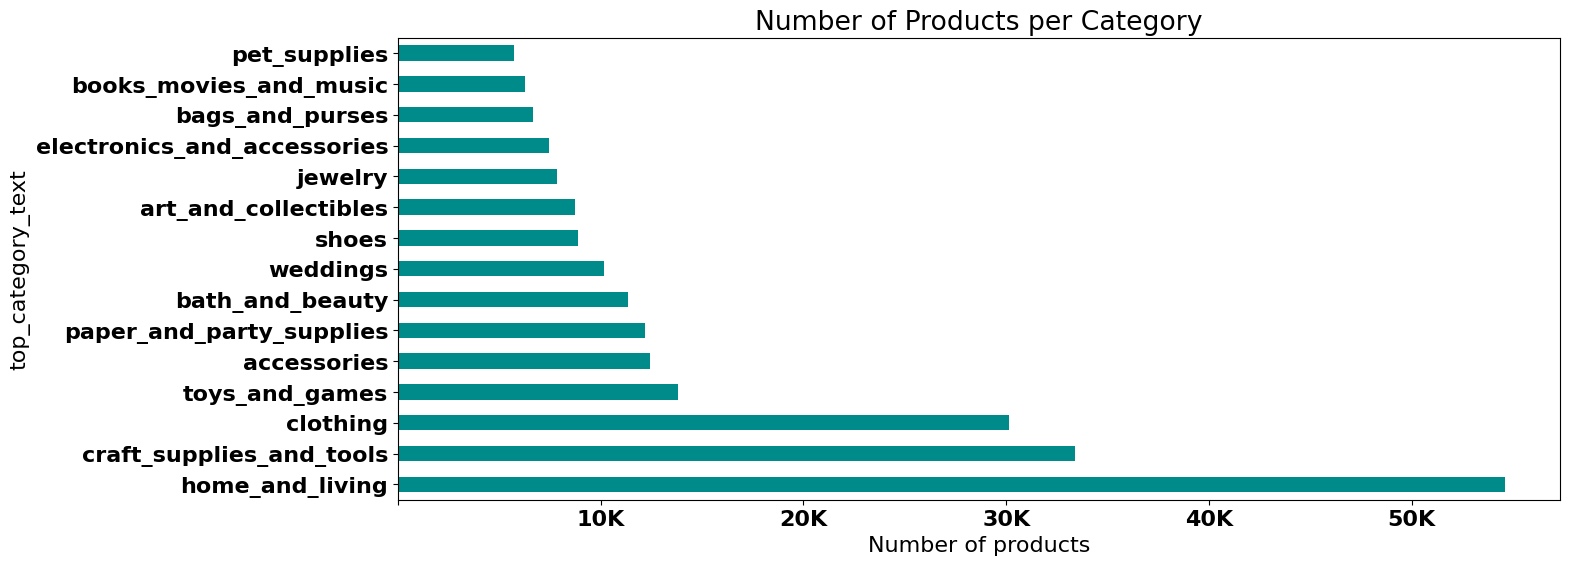

In [ ]:
figsize = (15, 6)
column = 'top_category_text'
x_limit = 60000
x_step = 10000
color = 'darkcyan'

figure, ax = plt.subplots(figsize=figsize)
pd.value_counts(
    df_train[column],
    sort=True, ascending=False).plot.barh(color=color)
plt.title(f"Number of Products per Category")
xlabels = [f'{x // 1000:,}K' for x in range(0, x_limit, x_step)]
plt.xticks(range(0, x_limit, x_step), xlabels)
plt.xlabel('Number of products')
plt.setp(ax.get_xticklabels()[0], visible=False)
plt.show()

In [ ]:
f"Number of bottom categories in train: {len(df_train['bottom_category_text'].unique()):,}"

'Number of bottom categories in train: 2,609'

# Test Dataset

The test dataset will be used to predict using the model/s you have trained

**Note** that categories and colors for the test data are hidden, you have to predict them!

In [ ]:
df_test = read_data("test", parquet_filenames_test)

In [ ]:
f'Number of rows in test: {len(df_test):,}'

'Number of rows in test: 25,514'

In [ ]:
f"Number of unique products in test: {len(df_test['product_id'].unique()):,}"

'Number of unique products in test: 25,514'

In [ ]:
f"Number of columns in test: {len(df_test.columns):,}"

'Number of columns in test: 15'

In [ ]:
list(df_test.columns)

['product_id',
 'title',
 'description',
 'tags',
 'type',
 'room',
 'craft_type',
 'recipient',
 'material',
 'occasion',
 'holiday',
 'art_subject',
 'style',
 'shape',
 'pattern']

In [ ]:
df_test.head()

,product_id,title,description,tags,type,room,craft_type,recipient,material,occasion,holiday,art_subject,style,shape,pattern
0,661373440,"Classroom Valentine Favors, Valentine Pencils,...","Valentine Favors, Robots of Love Vinyl Pencil ...","Valentines day favor,kindergarten treats,valen...",physical,,kids' crafts,,,,valentine's day,,,,
1,1501009290,5 Colour Slatepencils In One Pack Order NOw,5 Colour Slatepencils In One Pack Order NOw\n\...,"slatepencils,clay,nakumatt,edibleclay",physical,,drawing & drafting,,,,,,,,
2,1105447030,"No 2 Pencils by Associated Commercial, #2 Wri...","This listing is for a dozen, unused pre sharpe...","Faber Castell,aw faber,Faber-Castell,antique p...",physical,,drawing & drafting,,,,,,,,
3,1140081090,"Personalized Carpenter Pencils, Engraved Carpe...",EtchThisOut is now offering Carpenter Pencils ...,"Personalized Pencils,Carpenter Pencils,Carpent...",physical,,drawing & drafting,,,birthday,valentine's day,,,,
4,793448890,Vintage 1960&#39;s Autopoint mechanical pencil...,Vintage 1950&#39;s Autopoint mechanical pencil...,"Mechanical pencil,Autopoint pencil,Drafting pe...",physical,,calligraphy,,,,,,,,


## Model Training

Let's first split the data to be able to evaluate our model against a validation dataset. This validation set can also be used to fine tune your model before making the predictions on the hidden test set.

In [ ]:
from sklearn.model_selection import train_test_split

df_training, df_validation = train_test_split(
    df_train,
    test_size=0.1,
    stratify=df_train['bottom_category_text'],
    random_state=42)

In [ ]:
f"Number of products for training: {len(df_training):,}"

'Number of products for training: 206,661'

In [ ]:
f"Number of products for validation: {len(df_validation):,}"

'Number of products for validation: 22,963'

In [ ]:
df_training['bottom_category_text'].value_counts()

,count
bottom_category_text,
art_and_collectibles.drawing_and_illustration.architectural_drawings,88
accessories.scarves_and_wraps.scarves,88
craft_supplies_and_tools.closures_and_fasteners.buttons,88
toys_and_games.sports_and_outdoor_games.martial_arts_and_boxing.boxing_gloves,88
home_and_living.kitchen_and_dining.dining_and_serving.cake_stands,88
...,...
weddings.clothing.jumpsuits_and_rompers,40
home_and_living.furniture.entryway_furniture.standing_coat_racks,40
home_and_living.lighting.light_accessories,39


In [ ]:
df_validation['bottom_category_text'].value_counts()

In [ ]:
df_training['top_category_text'].value_counts()

,count
top_category_text,
home_and_living,49140
craft_supplies_and_tools,30056
clothing,27139
toys_and_games,12448
accessories,11173
paper_and_party_supplies,10984
bath_and_beauty,10187
weddings,9128
shoes,8001


In [ ]:
df_validation['top_category_text'].value_counts()

,count
top_category_text,
home_and_living,5460
craft_supplies_and_tools,3337
clothing,3004
toys_and_games,1387
accessories,1243
paper_and_party_supplies,1223
bath_and_beauty,1140
weddings,1015
shoes,891


### Training

As a simple example, let's follow the [Working With Text Data](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html) tutorial from scikit-learn that:

- processes the text using `CountVectorizer`, that builds a dictionary of features and transforms documents to feature vectors
- extracts term frequencies and inverse document frequencies using `TfidfTransformer`, (see [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf))
- trains a naïve Bayes classifier, which gives us a nice baseline

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

In [ ]:
train_text = df_training['title'].fillna('').values

In [ ]:
train_labels = df_training['top_category_text'].values

In [ ]:
text_clf.fit(train_text, train_labels)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

### Evaluation

Using our validation dataset, compute a number of metrics to measure how well we generalize on our validation set.

In [ ]:
val_text = df_validation['title'].fillna('').values
val_labels = df_validation['top_category_text'].values

In [ ]:
index = 0
print(f"""
Product's title: {val_text[index][:80]}...
Prediction: '{text_clf.predict([val_text[index]])[0]}', Groundtruth: '{val_labels[index]}'
""".strip())

Product's title: Vintage enamel funnel - White metal funnel with handle - Large rusty funnel - Ki...
Prediction: 'home_and_living', Groundtruth: 'home_and_living'


In [ ]:
df_validation.iloc[0]

,1465
product_id,1085759015
title,Vintage enamel funnel - White metal funnel wit...
description,Vintage enamel funnel - White metal funnel wit...
tags,"Enamel Funnel,Vintage metal funnel,Enamelware ..."
type,physical
room,
craft_type,winemaking
recipient,
material,
occasion,


In [ ]:
val_text[:1]

array(['Vintage enamel funnel - White metal funnel with handle - Large rusty funnel - Kitchen pouring tool - Bulgarian enamelware - Old shabby chic'],
      dtype=object)

In [ ]:
predictions = text_clf.predict(val_text)

In [ ]:
f1 = metrics.f1_score(val_labels, predictions, average='weighted')

In [ ]:
f"F1 score: {f1:.4f}"

'F1 score: 0.6392'

In [ ]:
print(metrics.classification_report(val_labels, predictions))

                             precision    recall  f1-score   support

                accessories       0.84      0.41      0.55      1243
       art_and_collectibles       0.86      0.09      0.16       870
            bags_and_purses       0.93      0.29      0.45       664
            bath_and_beauty       0.94      0.46      0.62      1140
     books_movies_and_music       0.98      0.31      0.47       626
                   clothing       0.73      0.96      0.83      3004
   craft_supplies_and_tools       0.62      0.77      0.69      3337
electronics_and_accessories       0.96      0.49      0.65       747
            home_and_living       0.54      0.96      0.69      5460
                    jewelry       0.91      0.37      0.53       782
   paper_and_party_supplies       0.80      0.58      0.67      1223
               pet_supplies       0.93      0.28      0.43       574
                      shoes       0.95      0.73      0.83       891
             toys_and_games      

In [ ]:
metrics.confusion_matrix(val_labels, predictions)

array([[ 507,    0,    1,    4,    0,  269,  155,    0,  250,    2,    4,
           2,    2,    7,   40],
       [   5,   78,    0,    0,    0,   31,  137,    2,  593,    0,    7,
           1,    0,   12,    4],
       [   2,    0,  195,   11,    0,   44,  114,    1,  279,    0,    5,
           1,    1,    6,    5],
       [  11,    0,    4,  528,    0,   68,  129,    1,  383,    4,    3,
           1,    1,    6,    1],
       [   1,    3,    0,    0,  193,   12,   90,    4,  298,    0,   17,
           3,    0,    4,    1],
       [   7,    0,    0,    2,    1, 2894,   15,    0,   72,    1,    5,
           0,    2,    0,    5],
       [   5,    4,    0,    3,    0,   35, 2576,    1,  676,    2,   21,
           0,    4,    6,    4],
       [   1,    0,    3,    0,    1,   14,   87,  365,  259,    0,    5,
           1,    0,   11,    0],
       [   1,    4,    2,    5,    0,   44,  123,    3, 5235,    0,   27,
           2,    0,   11,    3],
       [  16,    0,    0,    2,    1,

**Note** that this is just a baseline that uses a naïve Bayes classifier and uses the `title` only as inputs, there are many more parameters that can be used in addition to multiple architectures and processing approaches

## Submission

Prepare a submission for the test data. Here I am using some dummy values, all zeros, as the ids for top categories, bottom categories, primary colors and secondary colors. Feed-forward the test data through your model, get the predictions per product and output them onto a file to be checked against the true values.

Happy Hacking!

In [ ]:
df_predictions = df_test.copy()

In [ ]:
# dummy values
df_predictions["top_category_id"] = np.zeros(len(df_test), dtype=int)
df_predictions["bottom_category_id"] = np.zeros(len(df_test), dtype=int)

In [ ]:
student_id = "12345689"
df_predictions[
    ["product_id", "top_category_id", "bottom_category_id"]
].to_parquet(f"predictions_{student_id}.parquet")